## Introducción a Regresión Logística Simple

### Variables Dependientes Binarias y Regresores Continuos

El modelo que revisamos en regresión **lineal** simple sirve para modelar la relación entre dos variables continuas: tanto la variable _independiente_ (o _explicativa_ ), $x$, como la _dependiente_ (o _explicada_ ), $y$, pueden tomar cualquier valor en los reales: $x, y\in \mathbb{R}$. De hecho, la identidad $y\in\mathbb{R}$ de la variable _explicada_ , $y$, permite modelar su variación como una densidad normal.

Sin embargo en muchos escenarios aplicados puede ser de interés modelar la relación entre otros tipos de variables. Uno de los más comunes consiste en modelar la relación entre una variable _explicada_ binaria, que únicamente puede tomar dos valores, $y\in [0,1]$, y una _explicativa_ real, $x\in\mathbb{R}$. 

Por ejemplo, nos puede interesar entender la relación entre la `edad` de una persona, y si tiene `alguna cicatriz`. Graficando `cicatriz` como función de `edad` podemos encontrar algo como:

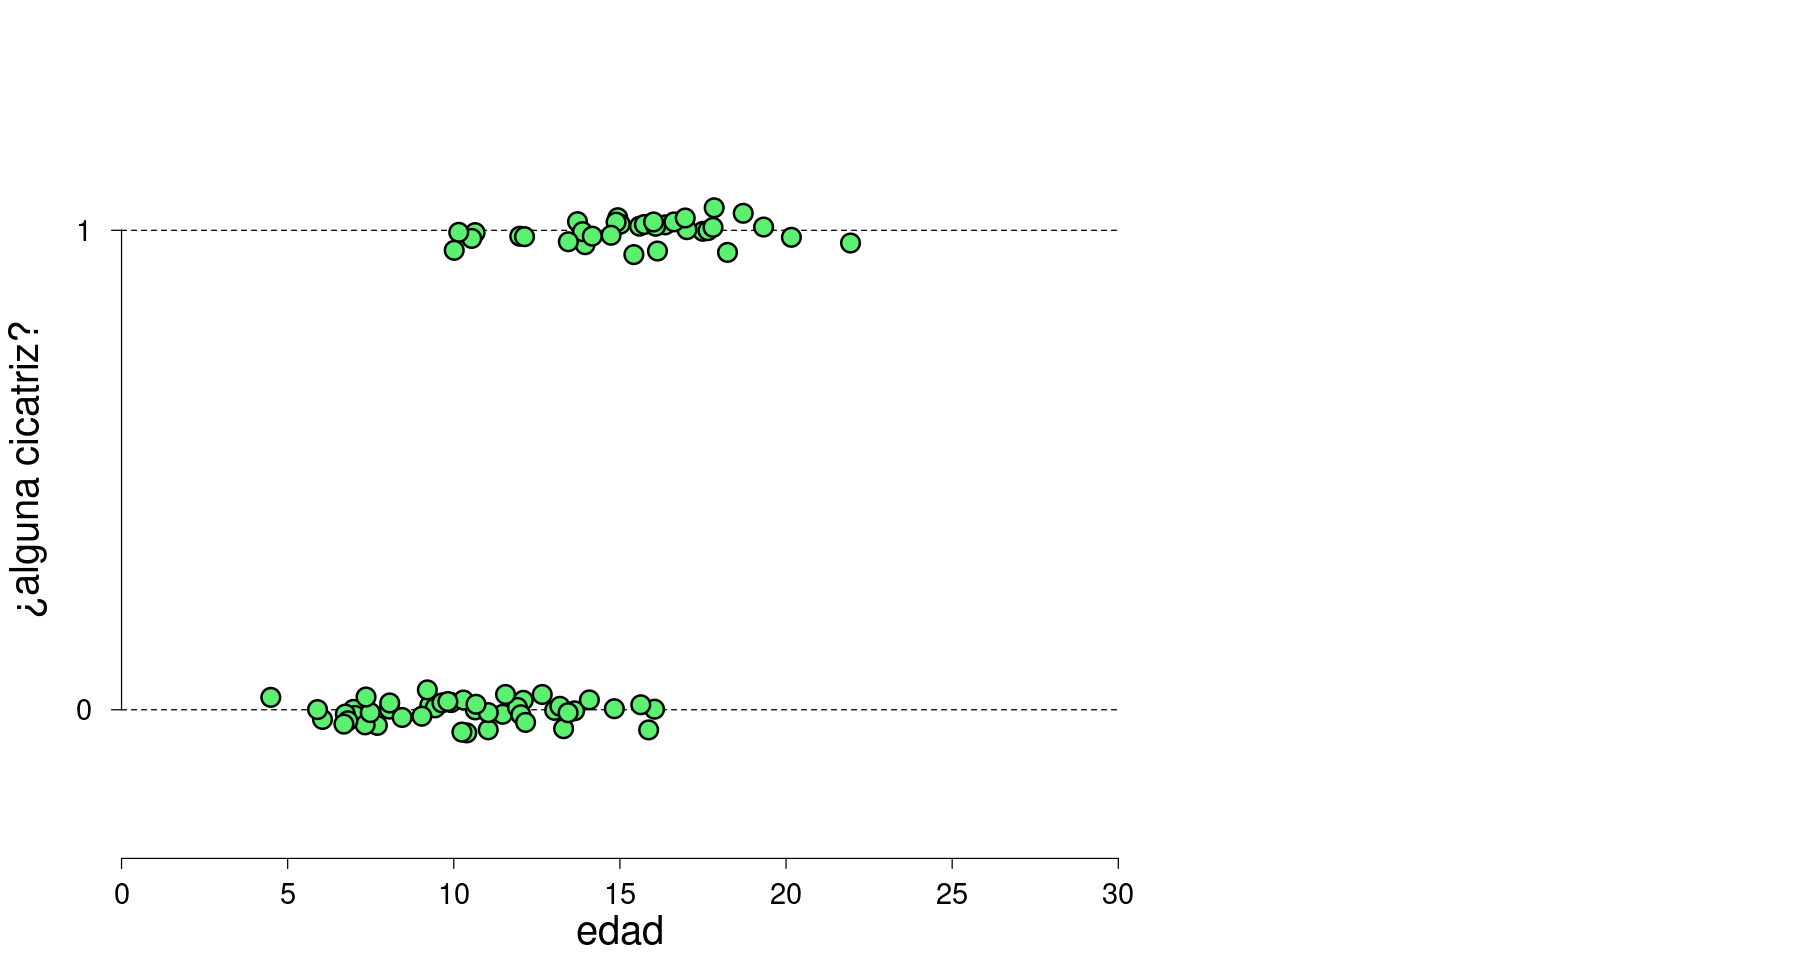

In [1]:
rm(list=ls())
set.seed(15)
b0 <- -10
b1 <- .75
x_simul <- rnorm(80,mean=12,sd=4)
y_simul <- rbinom(length(x_simul),size = 1,prob = 1/(1+exp(-(b0+b1*x_simul))))

col_data <- '#5cf070'

options(repr.plot.width = 15, repr.plot.height = 8)
layout(matrix(c(1,1,0,0),ncol=2),widths = c(2,1))
par(cex.axis=1.75,mgp=c(2,1.5,0))
plot(NULL,xlim=c(0,30),ylim=c(-.25,1.25),axes=F,ann=F)
segments(x0=rep(0,2),x1=rep(30,2),y0=c(0,1),y1=c(0,1),lty='dashed')
axis(1)
axis(2,at=c(0,1),las=1,pos=0)
mtext('edad',1,cex=2,line=3.5)
mtext('¿alguna cicatriz?',2,cex=2,line=2)
# Dos opciones para plotear este tipo de variables (categóricas)
# 1. Sin "jitter", datos "directos":
#points(x_simul,y_simul,cex=2.5,pch=21,bg=col_data,lwd=2)
# 2. Con "jitter": ruido *sin significado* sólo para visualizar mejor:
jitter <- rnorm(length(y_simul),mean=0,sd=0.02)
points(x_simul,y_simul+jitter,cex=2.5,pch=21,bg=col_data,lwd=2)

In [2]:
head(data.frame(x_simul,y_simul))
dim(data.frame(x_simul,y_simul))

x_simul   y_simul
1 13.035291 0      
2 19.324483 1      
3 10.641526 1      
4 15.588793 1      
5 13.952065 1      
6  6.978457 0

[1] 80  2

Intuitivamente parece que existe cierta relación entre ambas variables porque entre mayor edad es más común que la persona tenga una cicatriz. ¿Cómo podemos formalizar esta intuición?

En el modelo de regresión lineal simple utilizamos una densidad normal para describir el cambio en la variable explicada: $y\sim Gaussian(\mu_y,\sigma_y)$, en donde la tendencia central de dicha densidad, $\mu_y$, era una función lineal de la variable explicativa: $\mu_y \leftarrow \beta_0+\beta_1x$.

En el caso de la cicatriz y la edad, sin embargo, 1) **no** es adecuado utilizar la densidad normal porque la variable `cicatriz` es una **variable binaria**, mientras que el soporte de una densidad normal es una variable real, y 2) por lo tanto el parámetro que depende de la variable explicativa **no** es la media de $y$, sino la probabilidad de $y$, $\theta_y$.

En general, los modelos logísticos suponen que la variable explicada:

$$y\sim Bernoulli(\theta_y)$$

y que la probabilidad de $y$ es una función de la variable explicativa $x$:

$$\theta_y \leftarrow f(x)$$

En palabras, para explicar la relación entre la cicatriz y la edad, suponemos que entre mayor es la edad de una persona, mayor es la probabilidad de que tenga una cicatriz.

¿Cuál es la función que relaciona la probabilidad $\theta_y$ con el regresor $x$? 

Una posible alternativa podría ser utilizar una función lineal para describir dicha relación. Sin embargo esta alternativa es problemática porque, si bien parece funcionar en cierto rango restringido de $x$, genera predicciones inconsistentes en otros rangos del regresor:

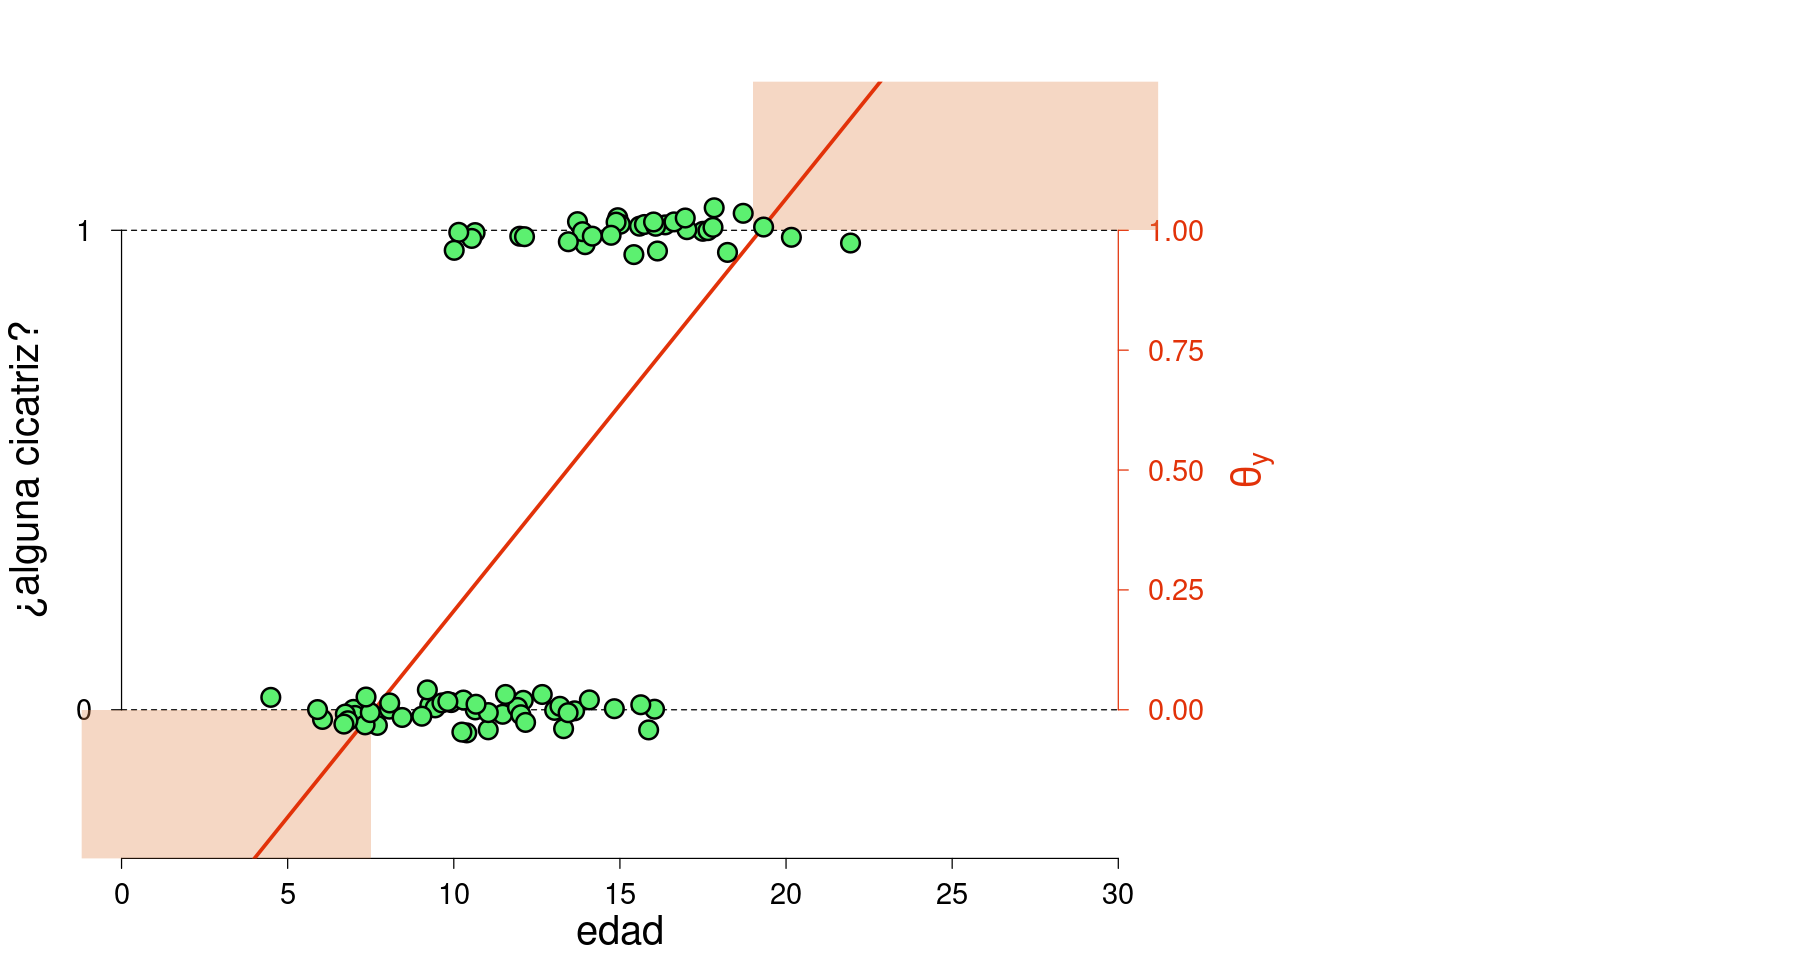

In [3]:
col_axis <- '#e23209'
options(repr.plot.width = 15, repr.plot.height = 8)
layout(matrix(c(1,1,0,0),ncol=2),widths = c(2,1))
par(cex.axis=1.75,mgp=c(2,1.5,0))
plot(NULL,xlim=c(0,30),ylim=c(-.25,1.25),axes=F,ann=F)
segments(x0=rep(0,2),x1=rep(30,2),y0=c(0,1),y1=c(0,1),lty='dashed')
axis(1)
axis(2,at=c(0,1),las=1,pos=0)
axis(4,at=c(0,0.25,0.5,0.75,1),las=1,pos=30,col=col_axis,col.axis=col_axis)
mtext('edad',1,cex=2,line=3.5)
mtext('¿alguna cicatriz?',2,cex=2,line=2)
mtext(expression('\u03b8'[y]),4,cex=2,line=5,col=col_axis)

polygon(x=c(-10,7.5,7.5,-10),y=c(-1,-1,0,0),border=NA,col='#e2874e55')
polygon(x=c(19,35,35,19),y=c(2,2,1,1),border=NA,col='#e2874e55')
abline(-0.654,0.086,lwd=3,col=col_axis)

# Dos opciones para plotear este tipo de variables (categóricas)
# 1. Sin "jitter", datos "directos":
#points(x_simul,y_simul,cex=2,pch=21,bg=col_data)
# 2. Con "jitter": ruido *sin significado* sólo para visualizar mejor:
points(x_simul,y_simul+jitter,cex=2.5,pch=21,bg=col_data,lwd=2)

### (Un) Modelo Logístico

Necesitamos una función definida para $x\in\mathbb{R}$ que genere resultados en $\theta_y\in(0,1)$. Existe una amplia familia de funciones que cumplen estas restricciones, conocidas como **modelos logísticos**. Estos modelos tienen la forma:

$$f(x)=\frac{1}{1+e^{-\alpha(x-x_o)}},$$

en donde la _tasa de crecimiento_ , $\alpha\in\mathbb{R}$, controla el ritmo de aumento de la curva, y el _punto medio_ , $x_0\in\mathbb{R}$, es el valor de la variable $x$ en donde la curva alcanza su punto medio. 

Conviene explorar gráficamente el comportamiento de esta ecuación para diferentes valores de $\alpha$ y de $x_0$:

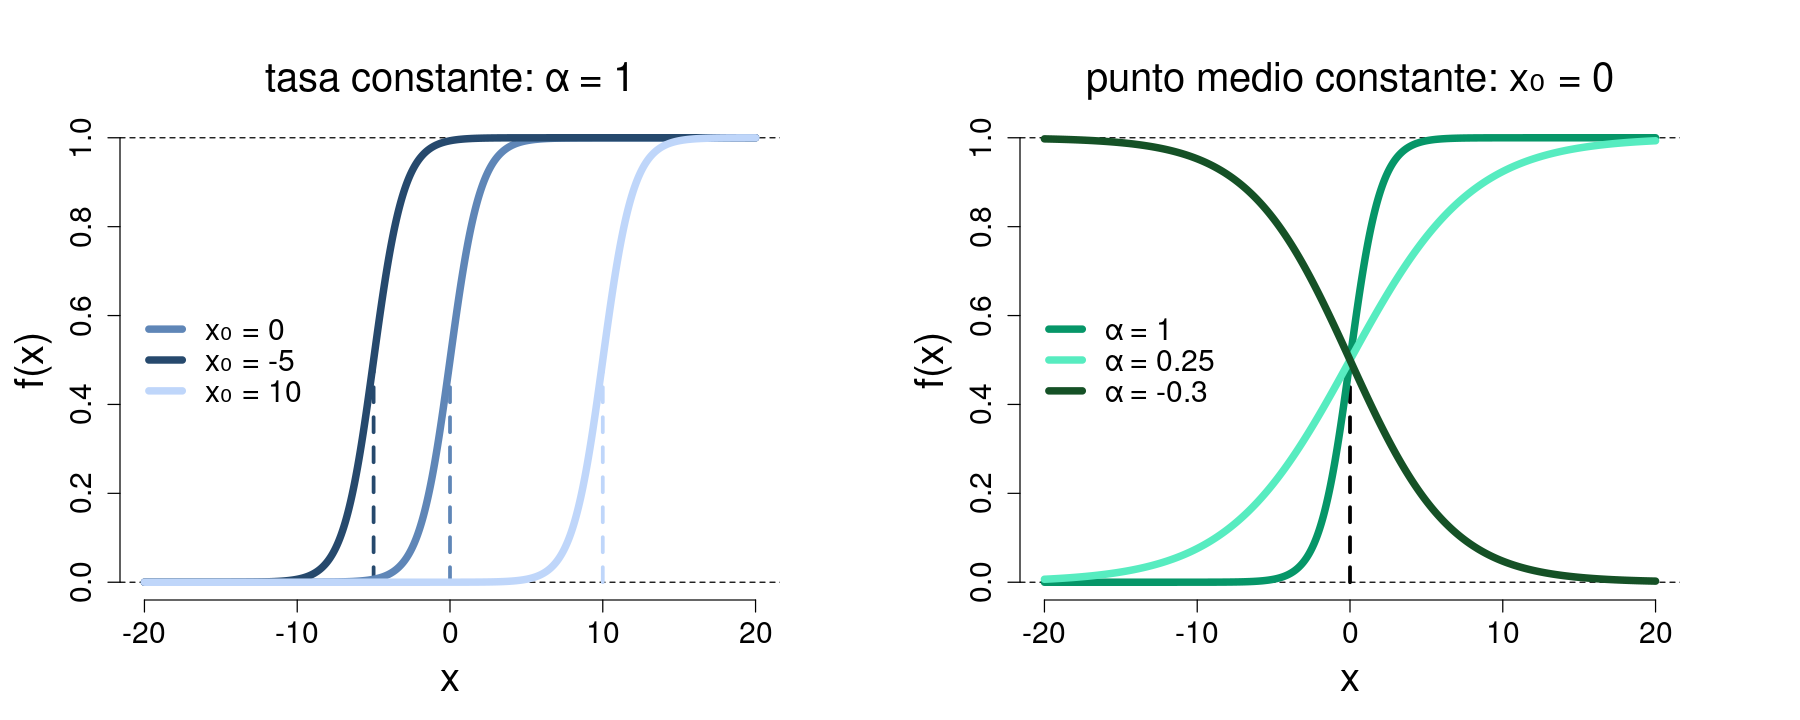

In [4]:
# Modelo Logístico
f_x <- function(x,a,x_0){
    return(1/(1+exp(-(a*(x-x_0)))))
}

options(repr.plot.width = 15, repr.plot.height = 6)
layout(matrix(1:2,ncol=2))
par(cex.axis=1.5,mar=rep(5,4))

x <- seq(-20,20,0.01)

# alpha constante:
plot(NULL,xlim=c(-20,20),ylim=c(0,1),ann=F,axes=F)
axis(1);axis(2);abline(h=c(0,1),lty='dashed')
x0 <- c(0,-5,10)
cols <- c("#5f86b7", "#26496d", "#bfd6fa") # Check: http://vrl.cs.brown.edu/color
segments(x0=x0,x1=x0,y0=rep(0,length(x0)),y1=rep(0.5,length(x0)),lty='dashed',col=cols,lwd=3)
for(i in 1:length(x0)){
    lines(x,f_x(x,1,x0[i]),col=cols[i],lwd=6)
}
legend(-27,.5,yjust=0.5,legend=paste('x\u2080 =',x0),
       lwd=6,col=cols,seg.len=.3,x.intersp=.2,text.width = 5,cex=1.5,box.lty='blank',bg=NA)
mtext('tasa constante: \u03b1 = 1',cex=2,line=1)
mtext('x',1,cex=2,line=3)
mtext('f(x)',2,cex=2,line=3)

# x0 constante:
plot(NULL,xlim=c(-20,20),ylim=c(0,1),ann=F,axes=F)
axis(1);axis(2);abline(h=c(0,1),lty='dashed')
alpha <- c(1,.25,-.3)
cols <- c("#069668", "#57ecc0", "#155126")
segments(x0=0,x1=0,y0=0,y1=0.5,lty='dashed',col='#000000',lwd=3)
for(j in 1:length(alpha)){
    lines(x,f_x(x,alpha[j],0),col=cols[j],lwd=6)
}
legend(-27,.5,yjust=0.5,legend=paste('\u03b1 =',alpha),
       lwd=6,col=cols,seg.len=.3,x.intersp=.2,text.width = 5,cex=1.5,box.lty='blank',bg=NA)
mtext('punto medio constante: x\u2080 = 0',cex=2,line=1)
mtext('x',1,cex=2,line=3)
mtext('f(x)',2,cex=2,line=3)
#abline(v=c(-2,2,10,14),lty='dotted',col='red')

En el modelo logístico la interpretación de la tasa de crecimiento no es tan inmediata como en el modelo lineal porque la curva logística crece a ritmos diferentes dependiendo de la posición en $x$ (i.e., su derivada no es constante). Sin embargo, la característica más general es que mientras dicho parámetro sea **positivo** la curva **aumenta** conforme $x$ aumenta, pero si es **negativo** la curva **decrementa** conforme $x$ _aumenta_ .

Otra diferencia importante es que en el modelo logístico elpunto medio $x_0$ está en escala **del regresor** $x$, a diferencia del modelo lineal en el que tanto pendiente como intercepto estaban en escala de la variable explicada. 

### Inferencia

En nuestro ejemplo, podemos utilizar la función logística para modelar la relación entre `edad` y la _probabilidad_ de tener una `cicatriz`. Junto con la especificación de la densidad sobre $y$, y de la incertidumbre a priori sobre $\alpha$ y $x_0$, tenemos un modelo completo que tal vez pueda explicar nuestras observaciones y, si ese es el caso, cuantificar, por ejemplo, a qué `edad` se vuelve más probable tener una cicatriz que no tenerla:

$$x_0\sim Gaussian(\mu=10,\sigma=1)$$

$$\alpha\sim Gaussian(\mu=0,\sigma=1)$$

$$\theta_{y_{i}}|\alpha, x_0, x_i\leftarrow\frac{1}{1+e^{-\alpha(x_{i}-x_0)}}$$

$$y_i|\theta_{y_{i}}\sim Bernoulli(\theta_{y_{i}})$$

In [5]:
# Observed 
y <- y_simul
x <- x_simul
n_obs <- length(x)
data_jags <- list('x','y','n_obs')

# Unobserved
unobs <- c('alpha_post','alpha_prior',
          'x0_post','x0_prior',
           'theta_y_post','theta_y_prior',
          'y_postdict_post','y_postdict_prior')

# Model
write('model{

alpha_post~dnorm(0,1)
alpha_prior~dnorm(0,1)
x0_post~dnorm(10,1)
x0_prior~dnorm(10,1)

for(i in 1:n_obs){
    theta_y_post[i] <- 1/(1+exp(-alpha_post*(x[i]-x0_post)))
    theta_y_prior[i] <- 1/(1+exp(-alpha_prior*(x[i]-x0_prior)))
    y[i]~dbern(theta_y_post[i])
    y_postdict_post[i]~dbern(theta_y_post[i])
    y_postdict_prior[i]~dbern(theta_y_prior[i])
}

}
','simple_logistic_regression.bug')

library('R2jags')
set.seed(18)
bayes <- jags(data=data_jags,
             parameters.to.save=unobs,
             model.file='simple_logistic_regression.bug',
             n.chains=3,
             n.iter=20000,
             n.burnin=5000,
             n.thin=5)
nds <- bayes$BUGSoutput$sims.list
summary(bayes$BUGSoutput$summary[,'Rhat'])

Loading required package: rjags

Loading required package: coda

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs


Attaching package: ‘R2jags’


The following object is masked from ‘package:coda’:

    traceplot


module glm loaded



Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 80
   Unobserved stochastic nodes: 164
   Total graph size: 1130

Initializing model



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.001   1.001   1.001   1.001   1.001   1.004 

### Distribución Postdictiva

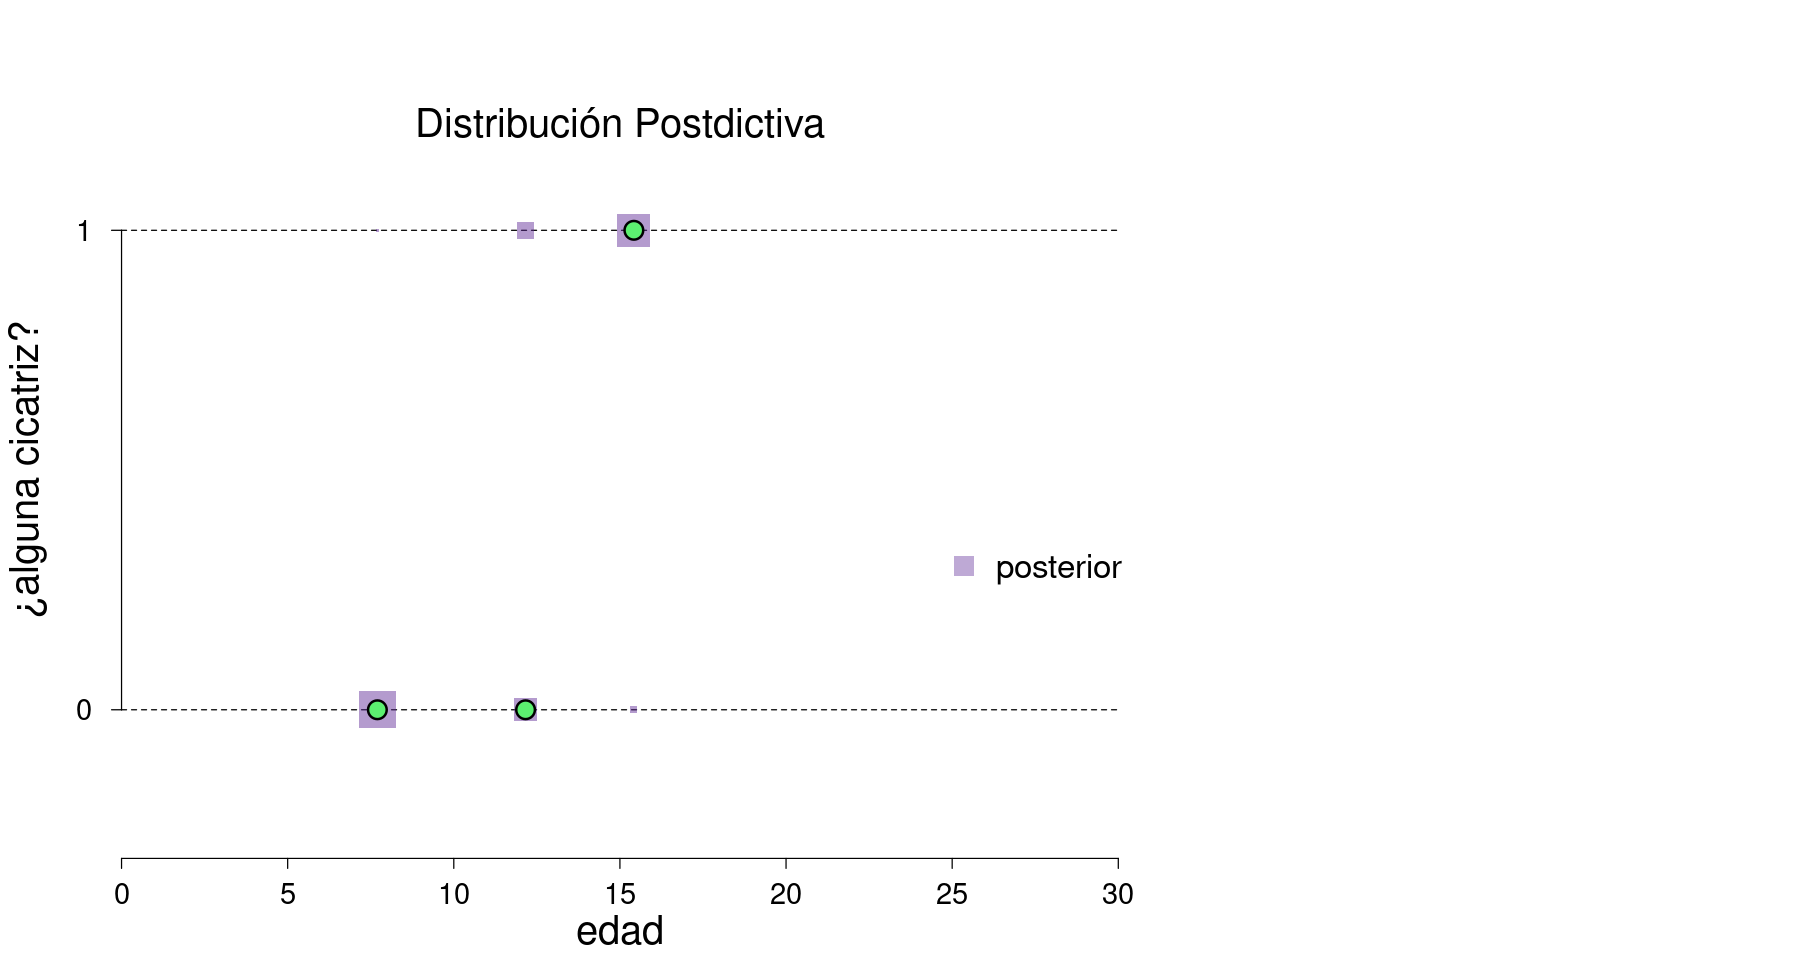

In [6]:
col_prior <- '#daa4f9'
col_post <- '#5e2a96'

options(repr.plot.width = 15, repr.plot.height = 8)
layout(matrix(c(1,1,0,0),ncol=2),widths = c(2,1))
par(cex.axis=1.75,mgp=c(2,1.5,0))
plot(NULL,xlim=c(0,30),ylim=c(-.25,1.25),axes=F,ann=F)
segments(x0=rep(0,2),x1=rep(30,2),y0=c(0,1),y1=c(0,1),lty='dashed')
axis(1)
axis(2,at=c(0,1),las=1,pos=0)
mtext('edad',1,cex=2,line=3.5)
mtext('¿alguna cicatriz?',2,cex=2,line=2)
mtext('Distribución Postdictiva',3,cex=2,line=-3)
# Observation to highlight:
highlight <- c(10,11,75)
for(h in highlight){
    postdiction <- nds$y_postdict_post[,h]
    post_1 <- sum(postdiction)/length(postdiction)
    post_0 <- 1-post_1
    points(x=rep(x_simul[h],2),y=c(0,1),cex=c(post_0,post_1)*6,pch=22,bg=paste(col_post,'77',sep=''),col=NA)
}
legend(23,0.3,yjust=0.5,pt.cex=3,
       pch=22,pt.bg=paste(col_post,'66',sep=''),
       col=NA,legend=,'posterior',
       seg.len=.3,cex=2,x.intersp=.4,text.width=3,box.lty='blank',bg='#ffffff88')

points(x_simul[highlight],y_simul[highlight],cex=2.5,pch=21,bg=col_data,lwd=2)

In [7]:
# ¿Cómo se ve la postdicción de JAGS? (obs. 75, la última posición de 'highlight' en la célula anterior)
postdiction
sum(postdiction)/length(postdiction)

[1] 1 1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 1 0 0 1 0 0 1 1 0 0 0 1 1 1
  [38] 0 0 0 0 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 0 0 0 1 0 0 1 0 0 1 1 1 1 0 0 1 0 0
  [75] 1 1 0 0 1 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 1 1 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0
 [112] 1 1 1 1 1 1 1 0 0 1 0 1 1 0 1 1 1 0 1 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1
 [149] 1 1 1 1 0 1 0 0 0 0 1 1 0 0 0 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 0 0 0 0 0 0 1
 [186] 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 0
 [223] 1 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 0 1 0
 [260] 0 0 1 0 0 1 1 0 0 1 0 1 0 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 1 0 0 0 1 0 0 0
 [297] 1 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 1 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 0
 [334] 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 0 0 1 1 1 0 1 0 1 1 0 1 0 0 0 0 1 0
 [371] 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 1
 [408] 1 1 0 1 0 1 1 0 0 0 1 0 0 1 1 1 0 1 0 1 1 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0
 [445] 1 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0 1 0 1 0 1 0 1 1 1 1 1
 [482] 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1
 [519] 0 0 1 0 1 0 1 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0 0 1 1 0
 [556] 1 1 1 1 0 0 1 0 1 1 0 1 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1 1
 [593] 1 0 0 1 0 0 1 1 0 0 1 0 1 0 0 1 0 0 0 1 0 1 0 1 1 1 1 0 0 1 0 0 1 0 1 1 0
 [630] 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0
 [667] 0 0 1 1 0 1 0 1 1 0 0 0 1 1 0 1 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 [704] 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 1 0
 [741] 1 1 1 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0
 [778] 1 0 1 1 0 0 1 1 0 0 1 0 1 1 1 0 0 0 0 1 0 1 1 1 0 1 1 0 1 1 0 0 0 0 0 0 0
 [815] 0 1 1 0 1 1 0 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1 1 0 1 1 1 0 1 0
 [852] 0 1 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1
 [889] 1 0 1 1 0 0 0 1 0 1 0 0 0 1 0 1 0 1 1 1 0 0 0 1 0 0 1 1 0 0 0 1 1 1 0 0 0
 [926] 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 0 1 1
 [963] 0 1 1 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 0 1 1 0 1 0 0 1 1 1 0 1 1 1 0 1 0 1 0
[1000] 1 0 1 1 1 0 0 1 1 0 1 1 0 0 0 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 1 0
[1037] 0 0 1 1 1 1 1 0 0 1 1 1 0 1 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 1 1 0 1 0 0
[1074] 0 0 0 0 0 1 0 1 0 0 1 1 1 0 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0
[1111] 1 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1
[1148] 1 0 0 1 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0
[1185] 0 1 0 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0 1 0 1 1 1 0 0 1 1 0 0 0 0 1 1 0 1 0 1
[1222] 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 0 0 1 1 0 0 0 0
[1259] 1 0 1 0 0 1 0 1 1 1 1 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0
[1296] 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 0 1 0
[1333] 0 0 1 1 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 0 1 0 1 0 1
[1370] 0 0 1 1 1 0 1 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1
[1407] 1 0 0 1 1 1 0 0 0 1 1 1 0 0 1 0 1 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 0 0 0 1
[1444] 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0
[1481] 1 1 0 1 0 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0
[1518] 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0
[1555] 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0
[1592] 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0
[1629] 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 1 0 1 1 0 1 0 1 1 0 1 0 0 1 0 0 1
[1666] 1 1 1 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0
[1703] 0 0 0 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1
[1740] 0 0 0 0 1 1 0 1 1 1 0 0 0 1 1 0 0 1 1 0 0 1 1 0 0 0 1 0 0 1 1 0 0 0 0 1 1
[1777] 0 1 0 0 0 1 1 1 1 0 1 0 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 1 0 0 1 1 1 1
[1814] 0 0 1 0 1 0 1 1 1 0 1 0 1 1

[1] 0.4232222

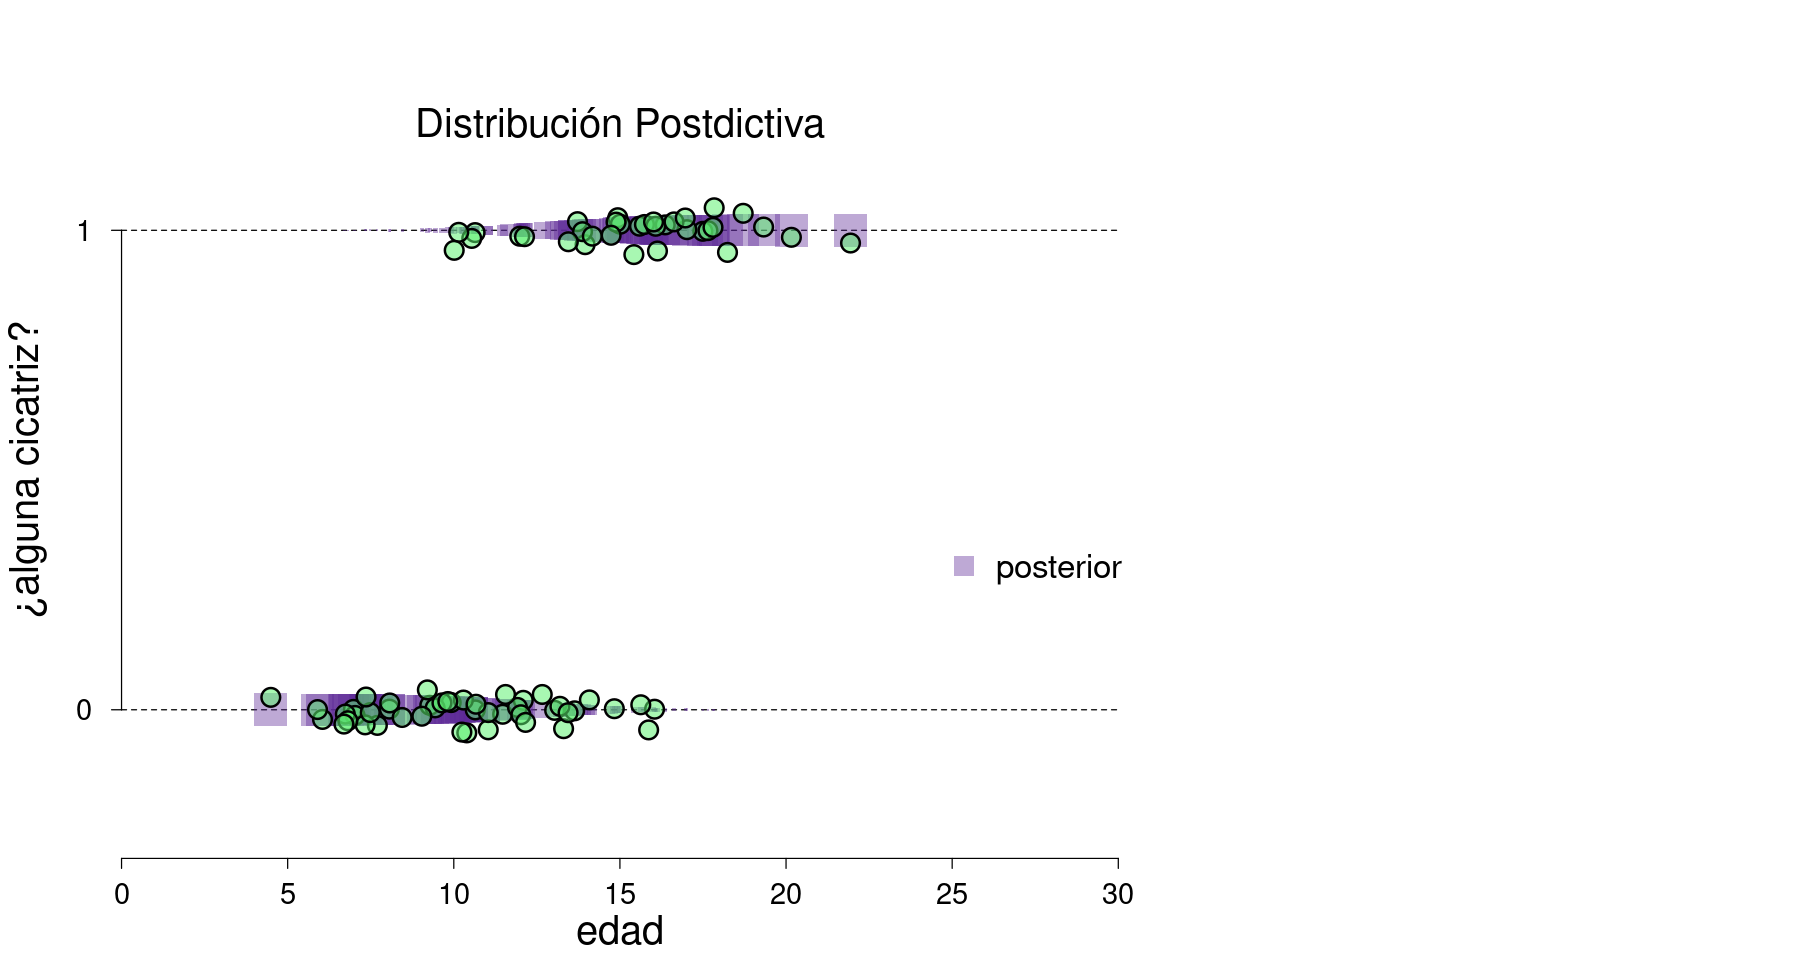

In [8]:
options(repr.plot.width = 15, repr.plot.height = 8)
layout(matrix(c(1,1,0,0),ncol=2),widths = c(2,1))
par(cex.axis=1.75,mgp=c(2,1.5,0))
plot(NULL,xlim=c(0,30),ylim=c(-.25,1.25),axes=F,ann=F)
segments(x0=rep(0,2),x1=rep(30,2),y0=c(0,1),y1=c(0,1),lty='dashed')
axis(1)
axis(2,at=c(0,1),las=1,pos=0)
mtext('edad',1,cex=2,line=3.5)
mtext('¿alguna cicatriz?',2,cex=2,line=2)
mtext('Distribución Postdictiva',3,cex=2,line=-3)
# Observation to highlight:
highlight <- 1:length(x_simul)
for(h in highlight){
    postdiction <- nds$y_postdict_post[,h]
    post_1 <- sum(postdiction)/length(postdiction)
    post_0 <- 1-post_1
    points(x=rep(x_simul[h],2),y=c(0,1),cex=c(post_0,post_1)*5,pch=22,bg=paste(col_post,'66',sep=''),col=NA)
}

legend(23,0.3,yjust=0.5,pt.cex=3,
       pch=22,pt.bg=paste(col_post,'66',sep=''),
       col=NA,legend=,'posterior',
       seg.len=.3,cex=2,x.intersp=.4,text.width=3,box.lty='blank',bg='#ffffff88')

points(x_simul,y_simul+jitter,cex=2.5,pch=21,bg=paste(col_data,'88',sep=''),lwd=2)

### Incertidumbre sobre $\theta_y$

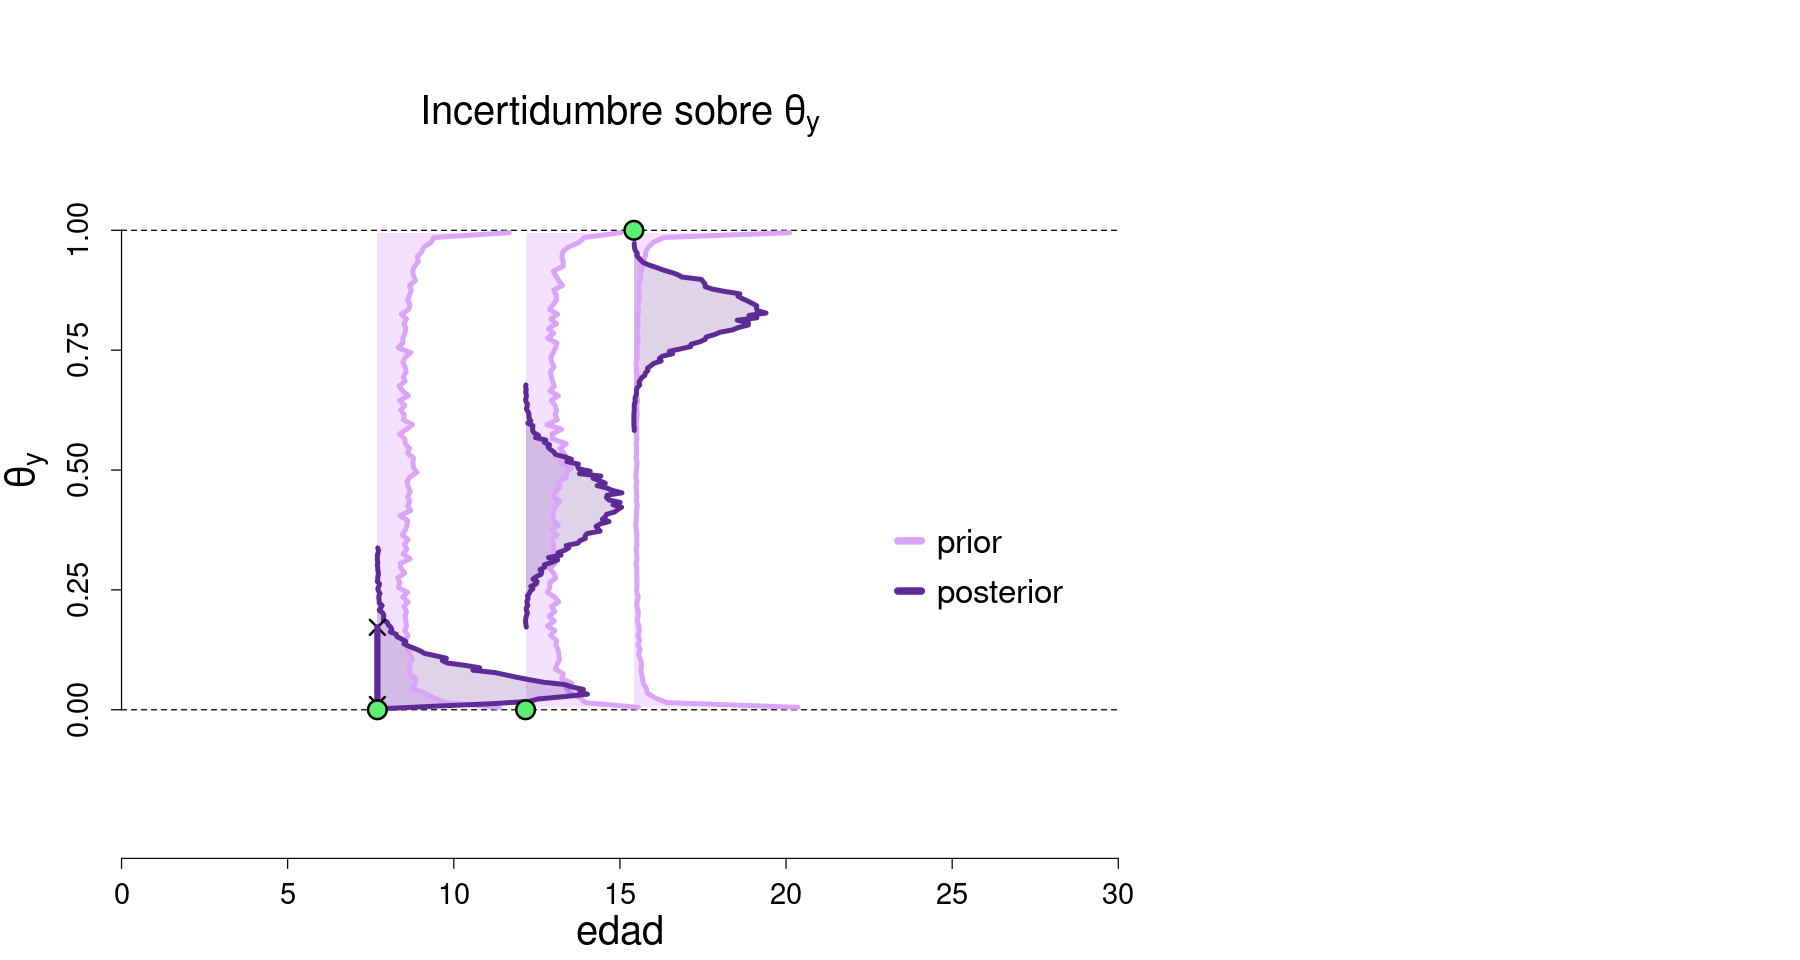

In [9]:
options(repr.plot.width = 15, repr.plot.height = 8)
layout(matrix(c(1,1,0,0),ncol=2),widths = c(2,1))
par(cex.axis=1.75,mgp=c(2,1.5,0))
plot(NULL,xlim=c(0,30),ylim=c(-.25,1.25),axes=F,ann=F)
segments(x0=rep(0,2),x1=rep(30,2),y0=c(0,1),y1=c(0,1),lty='dashed')
axis(1)
axis(2,at=seq(0,1,.25),pos=0)
mtext('edad',1,cex=2,line=3.5)
mtext(expression('\u03b8'[y]),2,cex=2,line=1.5)
mtext(expression(paste('Incertidumbre sobre \u03b8'[y])),3,cex=2,line=-3)
# Observation to highlight:
highlight <- c(75,11,10)
zoom_prior <- c(1,.25,1)
cnt <- 0
for(h in highlight){
    cnt <- cnt+1
    th_post <- hist(nds$theta_y_post[,h],breaks=80,plot=F)
    th_prior <- hist(nds$theta_y_prior[,h],breaks=80,plot=F)
    x_prr <- th_prior$density*zoom_prior[cnt]+x_simul[h]
    x_pst <- th_post$density*.5+x_simul[h]
    y_prr <- th_prior$mids
    y_pst <- th_post$mids
    polygon(x=c(x_simul[h],x_prr,x_simul[h]),y=c(head(y_prr,1),y_prr,tail(y_prr,1)),
            border=NA,col=paste(col_prior,'54',sep=''))
    polygon(x=c(x_simul[h],x_pst,x_simul[h]),y=c(head(y_pst,1),y_pst,tail(y_pst,1)),
            border=NA,col=paste(col_post,'34',sep=''))
    lines(x_prr,y_prr,col=col_prior,lwd=4)
    lines(x_pst,y_pst,col=col_post,lwd=4)
}
hdi_post <- quantile(nds$theta_y_post[,h],probs = c(0.025,0.975))
points(rep(x_simul[h],2),hdi_post,pch=4,cex=2,lwd=2)
lines(x=rep(x_simul[h],2),y=hdi_post,lwd=5,col=col_post)

legend(21,0.3,yjust=0.5,lwd=6,
       col=c(col_prior,col_post),legend=c('prior','posterior'),
       seg.len=.3,cex=2,x.intersp=.2,text.width=3,box.lty='blank',bg='#ffffff88')

points(x_simul[highlight],y_simul[highlight],cex=2.5,pch=21,bg=col_data,lwd=2)

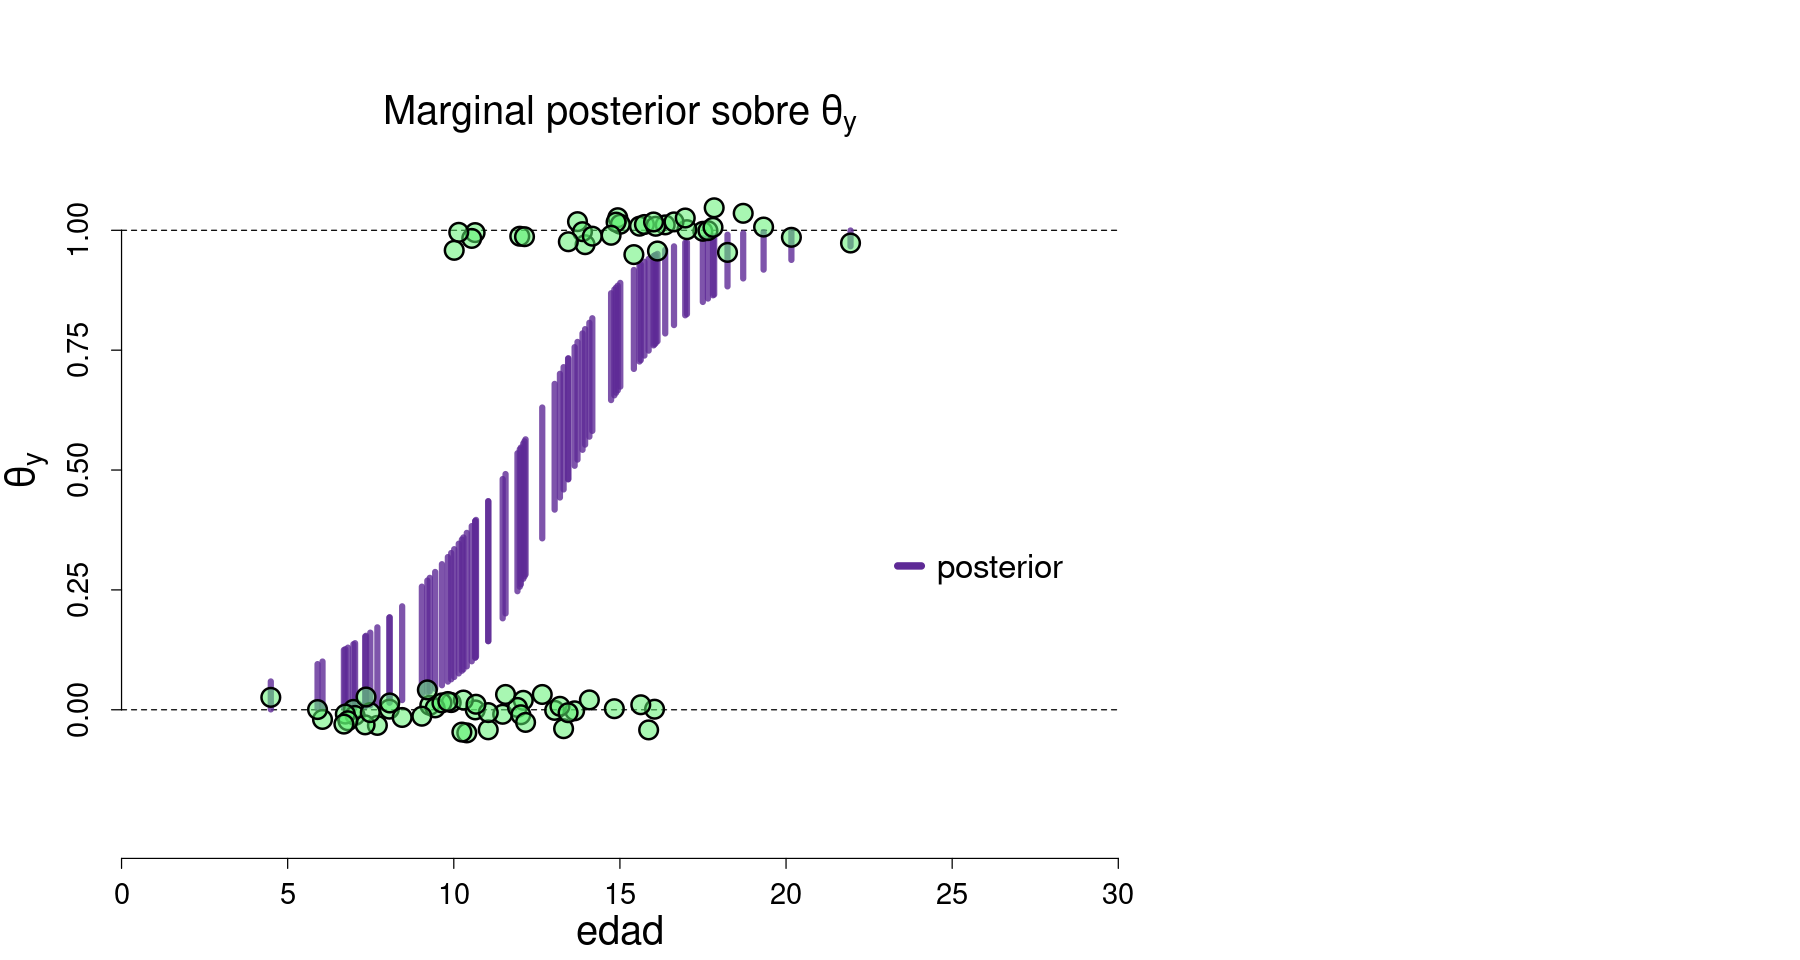

In [10]:
options(repr.plot.width = 15, repr.plot.height = 8)
layout(matrix(c(1,1,0,0),ncol=2),widths = c(2,1))
par(cex.axis=1.75,mgp=c(2,1.5,0))
plot(NULL,xlim=c(0,30),ylim=c(-.25,1.25),axes=F,ann=F)
segments(x0=rep(0,2),x1=rep(30,2),y0=c(0,1),y1=c(0,1),lty='dashed')
axis(1)
axis(2,at=seq(0,1,.25),pos=0)
mtext('edad',1,cex=2,line=3.5)
mtext(expression('\u03b8'[y]),2,cex=2,line=1.5)
mtext(expression(paste('Marginal posterior sobre \u03b8'[y])),3,cex=2,line=-3)
# Observation to highlight:
highlight <- 1:length(x_simul)
for(h in highlight){
    hdi_post <- quantile(nds$theta_y_post[,h],probs = c(0.025,0.975))
    lines(x=rep(x_simul[h],2),y=hdi_post,lwd=5,col=paste(col_post,'cc',sep=''))
}

legend(21,0.3,yjust=0.5,lwd=6,
       col=c(col_post),legend=c('posterior'),
       seg.len=.3,cex=2,x.intersp=.2,text.width=3,box.lty='blank',bg='#ffffff88')

points(x_simul,y_simul+jitter,cex=2.5,pch=21,bg=paste(col_data,'88',sep=''),lwd=2)

### Relaciones Logísticas Creíbles

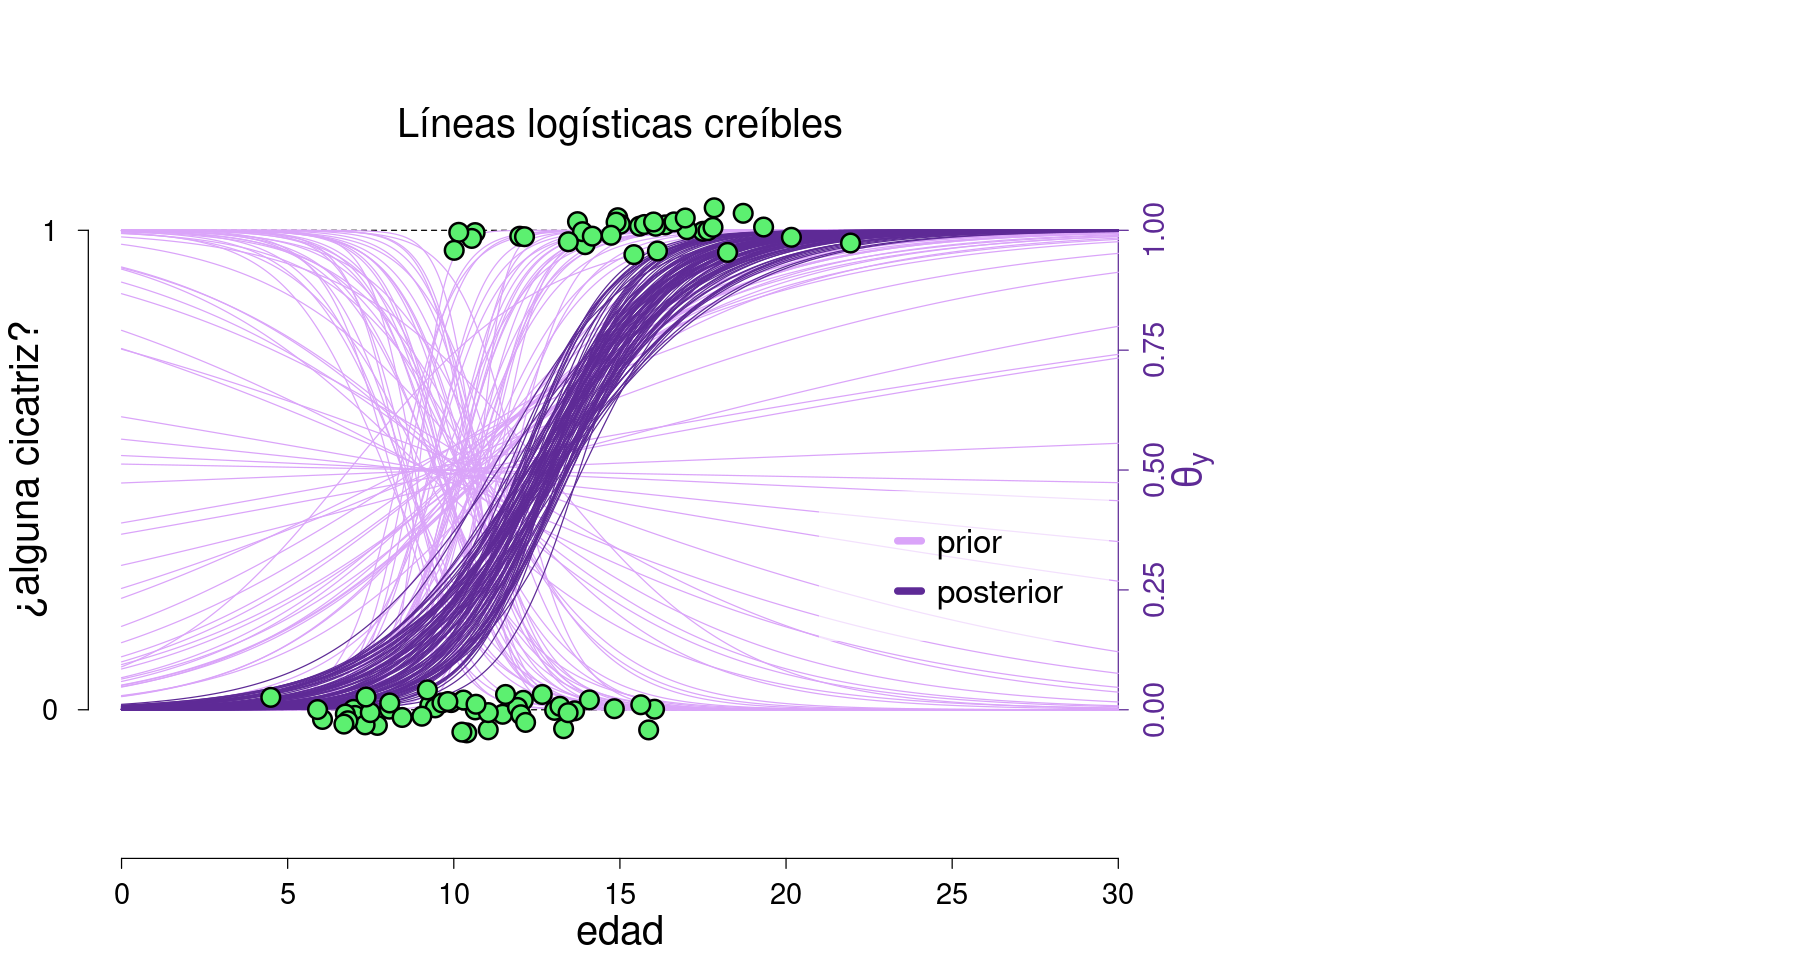

In [11]:
options(repr.plot.width = 15, repr.plot.height = 8)
layout(matrix(c(1,1,0,0),ncol=2),widths = c(2,1))
par(cex.axis=1.75,mgp=c(2,1.5,0))
plot(NULL,xlim=c(0,30),ylim=c(-.25,1.25),axes=F,ann=F)
segments(x0=rep(0,2),x1=rep(30,2),y0=c(0,1),y1=c(0,1),lty='dashed')
axis(1)
axis(2,at=c(0,1),las=1,pos=-1)
mtext('edad',1,cex=2,line=3.5)
mtext('¿alguna cicatriz?',2,cex=2,line=2)
mtext('Líneas logísticas creíbles',3,cex=2,line=-3)
axis(4,at=seq(0,1,.25),pos=30,col.axis=col_post,col=col_post)
mtext(expression('\u03b8'[y]),4,cex=2,line=2,col=col_post)
# indexes in JAGS to plot:
index <- sample(1:dim(nds$alpha_post)[1],size=100)
x_plot <- seq(0,30,0.01)
for(i in index){
    
    a_prior <- nds$alpha_prior[i]
    x0_prior <- nds$x0_prior[i]
    lines(x_plot,1/(1+exp(-a_prior*(x_plot-x0_prior))),col=col_prior)
}
for(i in index){
    a_post <- nds$alpha_post[i]
    x0_post <- nds$x0_post[i]
    lines(x_plot,1/(1+exp(-a_post*(x_plot-x0_post))),col=col_post)
}

legend(21,0.3,yjust=0.5,lwd=6,
       col=c(col_prior,col_post),legend=c('prior','posterior'),
       seg.len=.3,cex=2,x.intersp=.2,text.width=4,box.lty='blank',bg='#ffffffaa')

points(x_simul,y_simul+jitter,cex=2.5,pch=21,bg=col_data,lwd=2)

### Incertidumbre sobre $\alpha$ y $x_0$

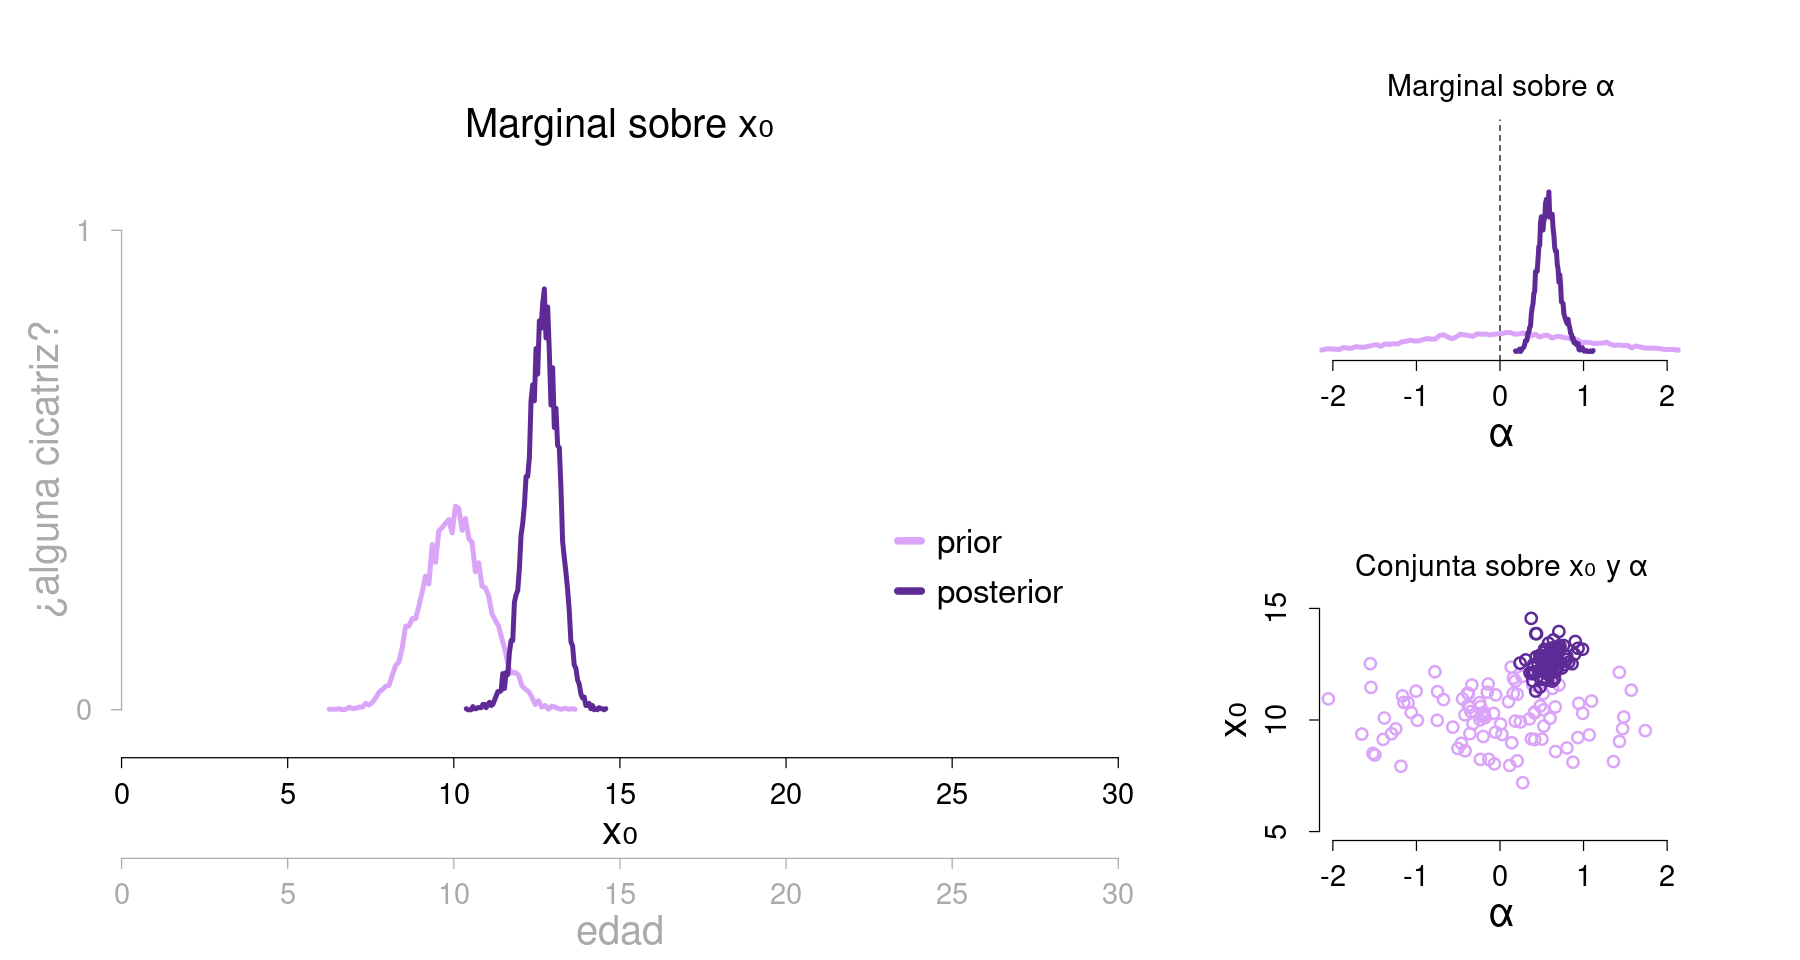

In [12]:
options(repr.plot.width = 15, repr.plot.height = 8)
layout(matrix(c(1,1,2,3),ncol=2),widths = c(2,1))
par(cex.axis=1.75,mgp=c(2,1.5,0))
plot(NULL,xlim=c(0,30),ylim=c(-.25,1.25),axes=F,ann=F)
axis(1,col='#aaaaaa',col.axis='#aaaaaa')
axis(2,at=c(0,1),las=1,pos=0,col='#aaaaaa',col.axis='#aaaaaa')
mtext('edad',1,cex=2,line=3.5,col='#aaaaaa')
axis(1,pos=-0.1)
mtext('x\u2080',1,cex=2,line=-1.5)
mtext('¿alguna cicatriz?',2,cex=2,line=1,col='#aaaaaa')
mtext('Marginal sobre x\u2080',3,cex=2,line=-3)
x0_pst <- hist(nds$x0_post,breaks=100,plot=F)
x0_prr <- hist(nds$x0_prior,breaks=100,plot=F)
lines(x0_prr$mids,x0_prr$density,col=col_prior,lwd=4)
lines(x0_pst$mids,x0_pst$density,col=col_post,lwd=4)
legend(21,0.3,yjust=0.5,lwd=6,
       col=c(col_prior,col_post),legend=c('prior','posterior'),
       seg.len=.3,cex=2,x.intersp=.2,text.width=3,box.lty='blank',bg='#ffffff88')
# Uncertainty over alpha
par(mar=rep(6,4))
plot(NULL,xlim=c(-2,2),ylim=c(0,5),axes=F,ann=F)
axis(1)
abline(v=0,lty='dashed')
alpha_pst <- hist(nds$alpha_post,breaks=100,plot=F)
alpha_prr <- hist(nds$alpha_prior,breaks=100,plot=F)
lines(alpha_prr$mids,alpha_prr$density,col=col_prior,lwd=4)
lines(alpha_pst$mids,alpha_pst$density,col=col_post,lwd=4)
mtext('\u03b1',1,cex=2,line=3.5)
mtext('Marginal sobre \u03b1',3,cex=1.5,line=1)

# Joint uncertainty over alpha and x0
plot(NULL,xlim=c(-2,2),ylim=c(5,15),axes=F,ann=F)
axis(1)
axis(2,at=c(5,10,15))
index <- sample(1:dim(nds$alpha_post)[1],size=100)
points(nds$alpha_prior[index],nds$x0_prior[index],cex=1.5,col=col_prior,lwd=2)
points(nds$alpha_post[index],nds$x0_post[index],cex=1.5,col=col_post,lwd=2)
mtext('\u03b1',1,cex=2,line=3.5)
mtext('x\u2080',2,cex=2,line=3.5)
mtext('Conjunta sobre x\u2080 y \u03b1',3,cex=1.5,line=1)

### Ejercicio: Otro Modelo Logístico

Es común encontrar el modelo logístico expresado de manera ligeramente diferente:

$$\theta_y=\frac{1}{1+e^{-(\beta_{0}+\beta_{1}x)}},$$

en donde los parámetros $\beta_0$ y $\beta_1$ representan características ligeramente diferentes a las que hemos estudiado. 

Expresa a los parámetros $\alpha$ y $x_0$ como función de $\beta_1$ y $\beta_0$, para que cuando encuentres reportes de estos dos últimos parámetros puedas traducirlos en términos de la tasa de crecimiento y del punto medio de la curva logística.

$$\alpha=f(\beta_1,\beta_0)$$

$$x_0=f(\beta_1,\beta_0)$$

Hint:

$$-(\beta_{0}+\beta_{1}x)=-\alpha(x-x_0)$$

Ambos lados de la ecuación ya tienen características similares, pero podemos hacer que se parezcan todavía más. Por ejemplo, factorizando $\beta_{1}$ del lado izquierdo:

$$-\beta_{1}\Big(\frac{\beta_{0}}{\beta_1}+x\Big)=-\alpha(x-x_0)$$

En donde $x$, dentro de las expresiones factorizadas, tiene el mismo signo en ambos lados de la ecuación.

#### Solución

Cambiando el orden de los términos en el paréntesis del lado izquierdo:

$$-\beta_{1}\Big(x+\frac{\beta_{0}}{\beta_1}\Big)=-\alpha(x-x_0)$$

Por lo tanto:

$$\alpha=\beta_1$$

$$x_0=-\frac{\beta_0}{\beta_1}$$

O de manera equivalente:

$$\beta_1=\alpha$$

$$\beta_0=-\beta_1 x_0=-\alpha x_0$$

La expresión de la curva logística en términos de $\beta_0$ y de $\beta_1$ permite resaltar su conexión con lo que se conoce como el *modelo lineal general*. Despejando el término exponencial en dicha expresión tenemos:

$$\theta_y=\frac{1}{1+e^{-(\beta_{0}+\beta_{1}x)}}$$

$$\frac{1}{\theta_y}=1+e^{-(\beta_{0}+\beta_{1}x)}$$

$$\frac{1}{\theta_y}-1=e^{-(\beta_{0}+\beta_{1}x)}$$

$$\frac{1}{\theta_y}-\frac{\theta_y}{\theta_y}=e^{-(\beta_{0}+\beta_{1}x)}$$

$$\frac{1-\theta_y}{\theta_y}=e^{-(\beta_{0}+\beta_{1}x)}$$

Calculando el logaritmo natural (i.e., base $e$) en ambos lados de la ecuación:

$$ln\Big(\frac{1-\theta_y}{\theta_y}\Big)=-(\beta_{0}+\beta_{1}x)$$

Multiplicando ambos lados por $-1$:

$$ln\Big(\frac{\theta_y}{1-\theta_y}\Big)=\beta_{0}+\beta_{1}x$$

El término $\frac{\theta_y}{1-\theta_y}$ es conocido como **razón de momios** (odds ratio), y es otra manera de cuantificar la probabilidad de un evento binario. Por ejemplo, si un evento tiene probabilidad de éxito $\theta=0.2$, la razón de momios correspondiente es $\frac{0.2}{0.8}=\frac{1}{4}$, o bien, el evento tiene momios 1:4 ("uno a cuatro") de éxito: si medimos el evento varias veces, por ejemplo, por cada éxito que registremos vamos a encontrar cuatro fracasos.

La expresión anterior permite entender al modelo de regresión logística como un caso especial del modelo lineal general. En concreto, esta expresión hace explícito que existe una _relación lineal_ entre el regresor $x$ y **el logaritmo de la razón de momios** de la probabilidad de éxito de la variable explicada $y$. 

En otras palabras, el modelo lineal general supone una relación lineal entre el regresor y _cierta_ característica de la variable explicada, pero necesitamos una función adicional para que esa característica sea consistente con la identidad de la variable binaria. Dicha función adicional se conoce como **link function**, y en el caso de la regresión logística es la función $ln\Big(\frac{\theta_y}{1-\theta_y}\Big)$.

### Otro ejemplo: Mosquitos Nórdicos

El conjunto de observaciones `picaduras_mosquito.csv` contiene mediciones de dos variables: la `edad` (en años) de la persona, y si alguna vez ha sido mordida por un `mosquito`, variables registradas con excepcional precisión en una población que habita un territorio del norte lejano a los trópicos.

Leyendo la base y explorando sus características más generales:


In [13]:
rm(list=ls())
msqt <- read.csv('~/Teaching/picaduras_mosquito.csv')
head(msqt);tail(msqt)
summary(msqt)
sum(msqt$mosquito)/length(msqt$mosquito)

edad mosquito
1 68.5 1       
2 86.5 1       
3 17.8 0       
4 44.3 1       
5 43.2 0       
6 57.3 1

edad mosquito
372 54.3 1       
373 54.9 1       
374 18.8 0       
375 67.6 1       
376 54.3 1       
377 71.8 1

      edad          mosquito     
 Min.   : 2.10   Min.   :0.0000  
 1st Qu.:35.70   1st Qu.:0.0000  
 Median :49.80   Median :1.0000  
 Mean   :48.76   Mean   :0.6207  
 3rd Qu.:62.00   3rd Qu.:1.0000  
 Max.   :94.40   Max.   :1.0000  

[1] 0.6206897

El diagrama de dispersión, que se muestra a continuación, sugiere una posible relación entre ambas variables, en tanto que parece que la propensión de personas con alguna picadura aumenta conforme aumenta su edad.

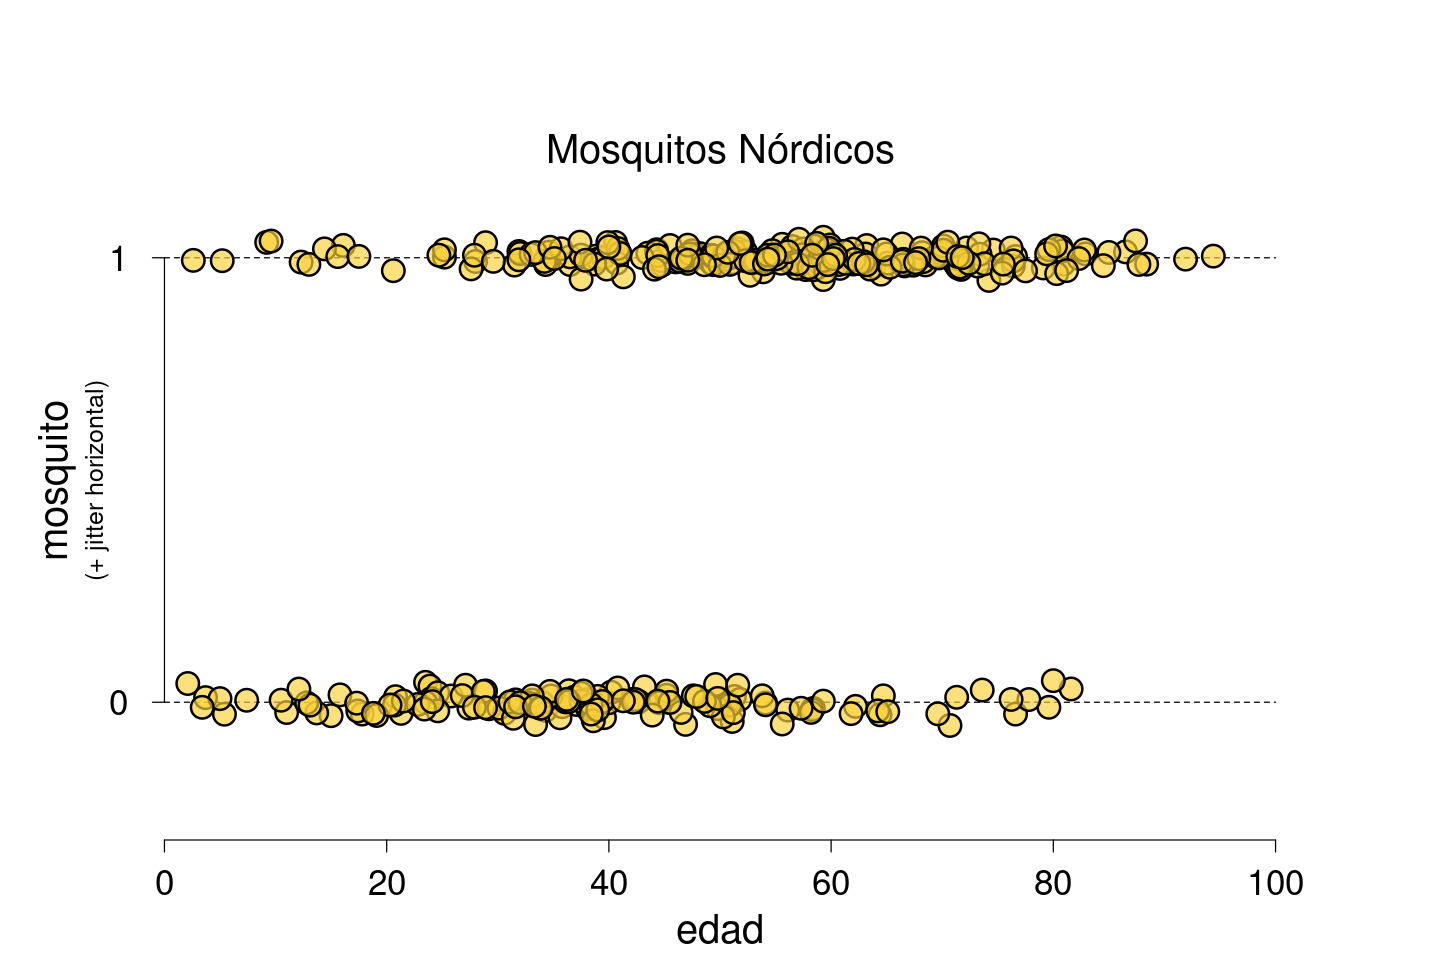

In [14]:
jitter <- rnorm(n=length(msqt$mosquito),mean=0,sd=0.02)
col_data <- '#fad139'

par(cex.axis=1.75,mgp=c(2,1.5,0),mar=rep(5,4))
options(repr.plot.width = 12, repr.plot.height = 8)
plot(NULL,xlim=c(0,100),ylim=c(-.25,1.25),axes=F,ann=F)
segments(x0=rep(0,2),x1=rep(100,2),y0=c(0,1),y1=c(0,1),lty='dashed')
axis(1)
axis(2,at=c(0,1),las=1,pos=0)
mtext('edad',1,cex=2,line=3.5)
mtext('mosquito',2,cex=2,line=2)
mtext('(+ jitter horizontal)',2,cex=1.25,line=0.5)
mtext('Mosquitos Nórdicos',3,cex=2,line=-2)
points(msqt$edad,msqt$mosquito+jitter,cex=2.5,pch=21,bg=paste(col_data,'aa',sep=''),lwd=2)

#### Ejercicio

Implementa el modelo logístico que estudiamos en la sección anterior con este conjunto de datos:

$$x_0\sim Gaussian(\mu=50,\sigma=10)$$

$$\alpha\sim Gaussian(\mu=0,\sigma=1)$$

$$\theta_{y_{i}}|\alpha, x_0, x_i\leftarrow\frac{1}{1+e^{-\alpha(x_{i}-x_0)}}$$

$$y_i|\theta_{y_{i}}\sim Bernoulli(\theta_{y_{i}})$$

y explora su **distribución postdictiva**: ¿crees que el modelo puede explicar _todas_ las observaciones? ¿Dónde crees que falla, si falla?

In [15]:
# Observed 
y <- msqt$mosquito
x <- msqt$edad
n_obs <- length(x)
data_jags <- list('x','y','n_obs')

# Unobserved
unobs <- c('alpha_post','alpha_prior',
          'x0_post','x0_prior',
           'theta_y_post','theta_y_prior',
          'y_postdict_post','y_postdict_prior')

# Model
write('model{

alpha_post~dnorm(0,1)
alpha_prior~dnorm(0,1)
x0_post~dnorm(50,.01)
x0_prior~dnorm(50,.01)

for(i in 1:n_obs){
    theta_y_post[i] <- 1/(1+exp(-alpha_post*(x[i]-x0_post)))
    theta_y_prior[i] <- 1/(1+exp(-alpha_prior*(x[i]-x0_prior)))
    y[i]~dbern(theta_y_post[i])
    y_postdict_post[i]~dbern(theta_y_post[i])
    y_postdict_prior[i]~dbern(theta_y_prior[i])
}

}
','2PL_logistic_regression.bug')

library('R2jags')
set.seed(18)
bayes <- jags(data=data_jags,
             parameters.to.save=unobs,
             model.file='2PL_logistic_regression.bug',
             n.chains=3,
             n.iter=15000,
             n.burnin=5000,
             n.thin=5)
nds_2pl <- bayes$BUGSoutput$sims.list # Note the 'nodes' name
summary(bayes$BUGSoutput$summary[,'Rhat'])

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 377
   Unobserved stochastic nodes: 758
   Total graph size: 4489

Initializing model



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.001   1.001   1.001   1.001   1.001   1.005 

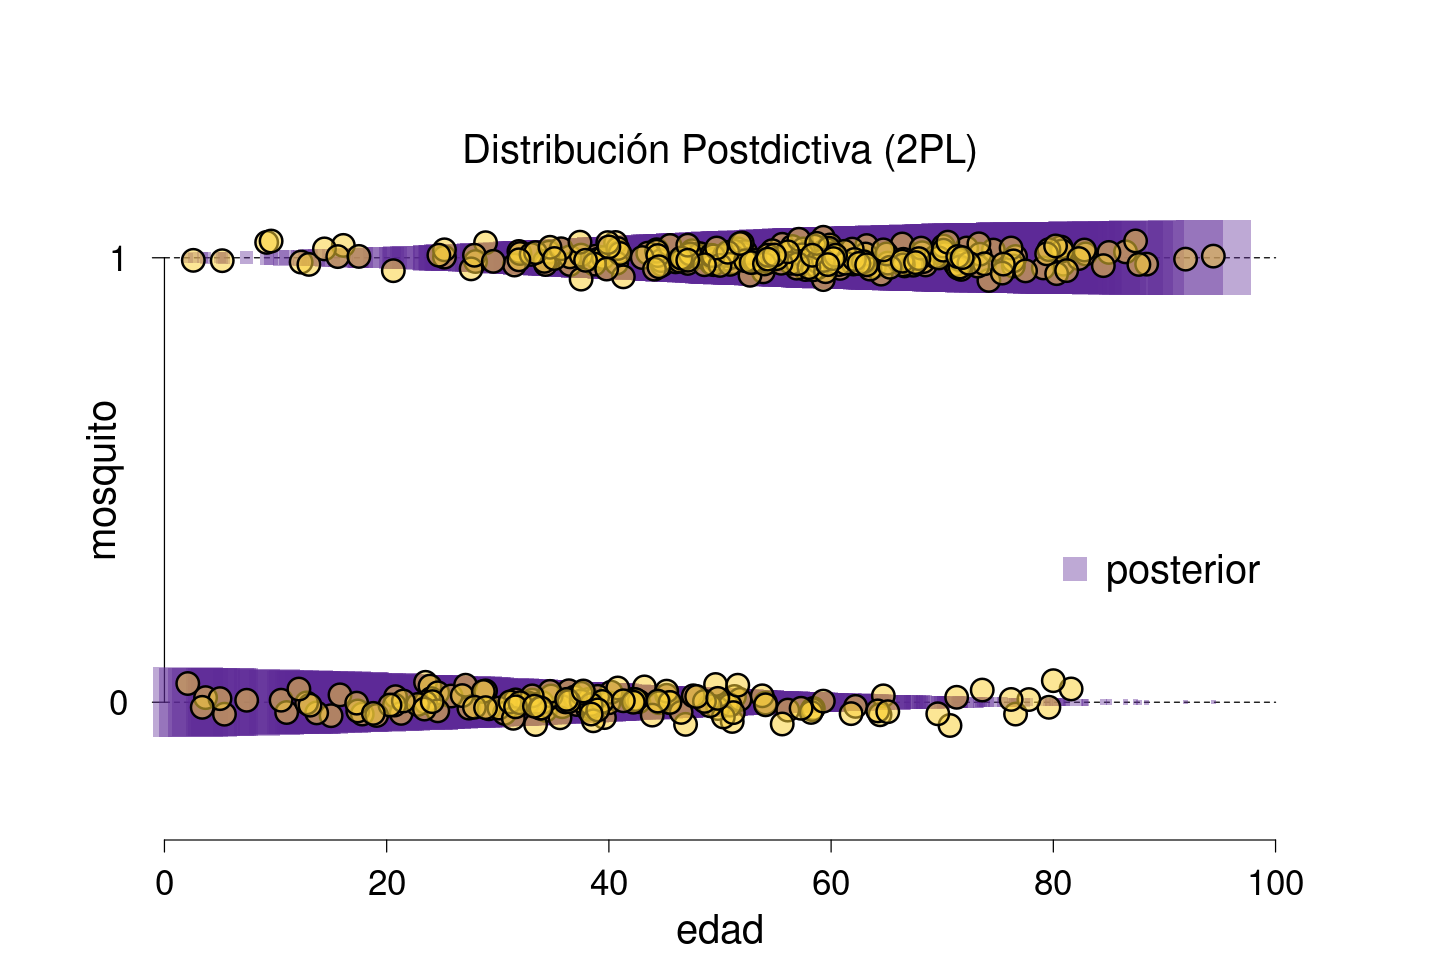

In [16]:
col_prior <- '#daa4f9'
col_post <- '#5e2a96'

options(repr.plot.width = 12, repr.plot.height = 8)
par(cex.axis=1.75,mgp=c(2,1.5,0),mar=rep(5,4))
plot(NULL,xlim=c(0,100),ylim=c(-.25,1.25),axes=F,ann=F)
segments(x0=rep(0,2),x1=rep(100,2),y0=c(0,1),y1=c(0,1),lty='dashed')
axis(1)
axis(2,at=c(0,1),las=1,pos=0)
mtext('edad',1,cex=2,line=3.5)
mtext('mosquito',2,cex=2,line=0)
mtext('Distribución Postdictiva (2PL)',3,cex=2,line=-2)
# Observation to highlight:
highlight <- 1:length(msqt$edad)
for(h in highlight){
    postdiction <- nds_2pl$y_postdict_post[,h] # We *ensure* this comes from 2PL!
    post_1 <- sum(postdiction)/length(postdiction)
    post_0 <- 1-post_1
    points(x=rep(msqt$edad[h],2),y=c(0,1),cex=c(post_0,post_1)*10,
           pch=22,bg=paste(col_post,'66',sep=''),col=NA)
}

legend(75,0.3,yjust=0.5,pt.cex=3,
       pch=22,pt.bg=paste(col_post,'66',sep=''),
       col=NA,legend=,'posterior',
       seg.len=.3,cex=2,x.intersp=.4,text.width=3,box.lty='blank',bg='#ffffff88')

points(msqt$edad,msqt$mosquito+jitter,cex=2.5,pch=21,bg=paste(col_data,'88',sep=''),lwd=2)

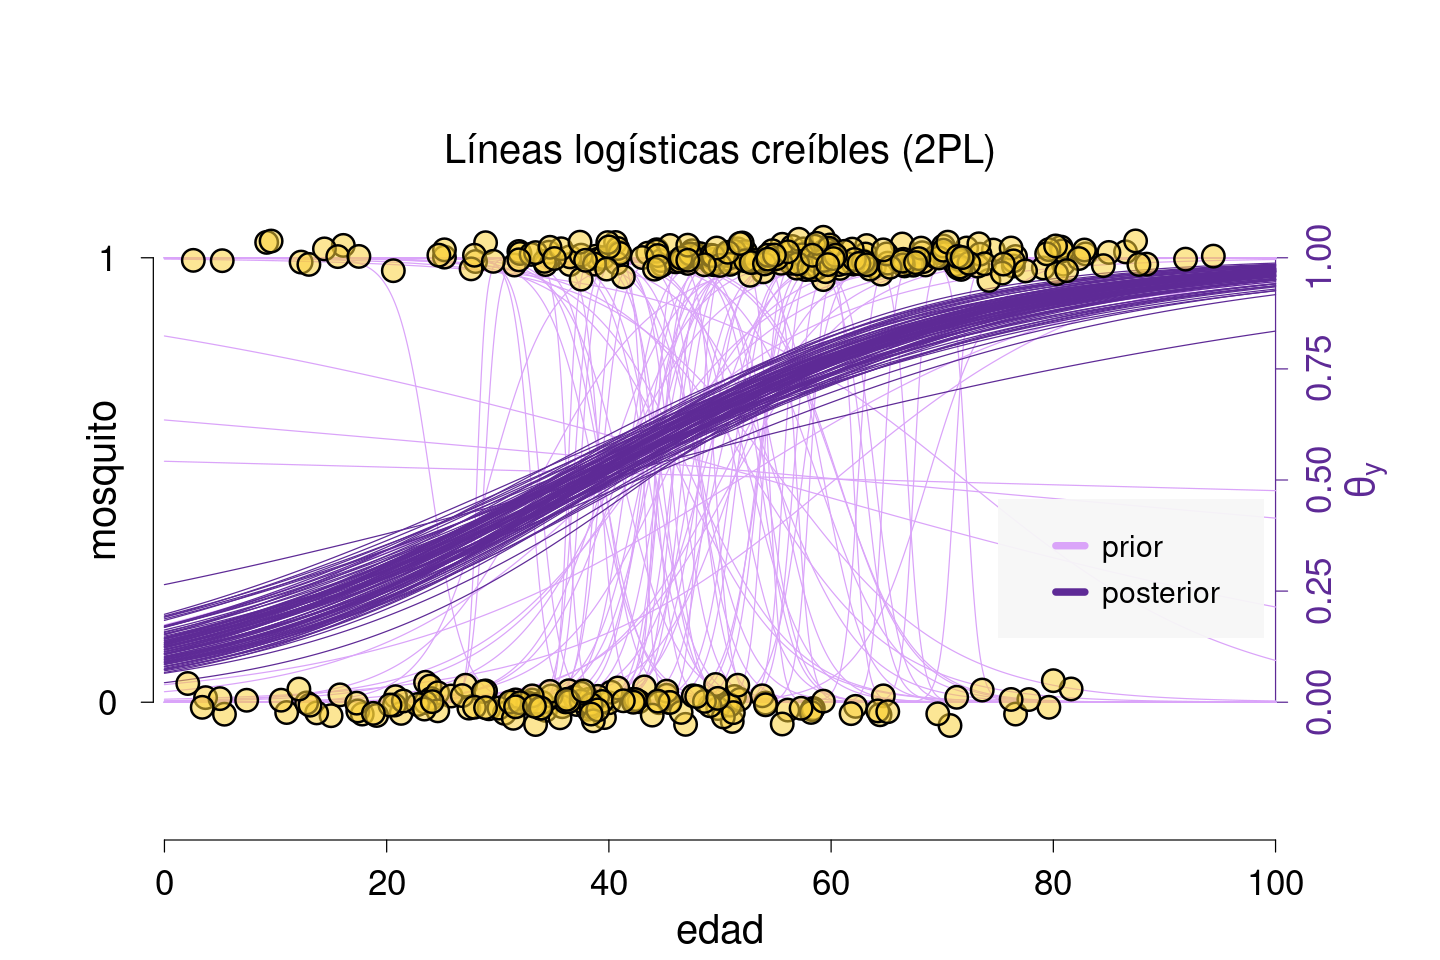

In [17]:
# Relaciones Logísticas Creíbles

options(repr.plot.width = 12, repr.plot.height = 8)
par(cex.axis=1.75,mgp=c(2,1.5,0),mar=rep(5,4))
plot(NULL,xlim=c(0,100),ylim=c(-.25,1.25),axes=F,ann=F)
segments(x0=rep(0,2),x1=rep(100,2),y0=c(0,1),y1=c(0,1),lty='dashed')
axis(1)
axis(2,at=c(0,1),las=1,pos=-1)
mtext('edad',1,cex=2,line=3.5)
mtext('mosquito',2,cex=2,line=0)
mtext('Líneas logísticas creíbles (2PL)',3,cex=2,line=-2)
axis(4,at=seq(0,1,.25),pos=100,col.axis=col_post,col=col_post)
mtext(expression('\u03b8'[y]),4,cex=2,line=2,col=col_post)
# indexes in JAGS to plot:
index <- sample(1:dim(nds_2pl$alpha_post)[1],size=100)
x_plot <- seq(0,100,0.01)
for(i in index){
    a_prior <- nds_2pl$alpha_prior[i]
    x0_prior <- nds_2pl$x0_prior[i]
    lines(x_plot,1/(1+exp(-a_prior*(x_plot-x0_prior))),col=col_prior)
}
for(i in index){
    a_post <- nds_2pl$alpha_post[i]
    x0_post <- nds_2pl$x0_post[i]
    lines(x_plot,1/(1+exp(-a_post*(x_plot-x0_post))),col=col_post)
}

legend(99,0.3,yjust=0.5,xjust=1,lwd=6,
       col=c(col_prior,col_post),legend=c('prior','posterior'),
       seg.len=.5,cex=1.5,x.intersp=.3,text.width=12,box.lty='blank',bg='#f6f6f6ee')

points(msqt$edad,msqt$mosquito+jitter,cex=2.5,pch=21,bg=paste(col_data,'88',sep=''),lwd=2)

Este primer modelo, también conocido como **modelo logístico de 2 parámetros** (two-parameter logistic model, a.k.a. "2PL") captura algunas características de las observaciones, pero tiene problemas para entender tanto las picaduras de mosquito en las personas muy jóvenes, como la ausencia de picaduras en personas mayores. Como estas son dos características del mundo natural que nos interesa explicar, necesitamos encontrar un modelo que las capture adecuadamente.

### (Otro) Modelo Logístico (más) General: 4PL (four-parameter logistic model)

Una extensión o generalización del modelo 2PL agrega asíntotas inferiores y superiores a la curva logística, es decir, 

1. asume que existe una probabilidad mínima _mayor que cero_ de tener una picadura *sin importar cuán pequeño el valor del regresor*, a diferencia del modelo 2PL que asumía que para rangos pequeños del regresor la probabilidad de éxito era _estrictamente_ igual a cero, y

2. asume que existe una probabilidad máxma _menor que uno_ de éxito *sin importar cuán grande el valor del regresor*, lo cual también contrasta con el modelo 2PL porque aquel suponía que cuando el regresor tiende a infinito la probabilidad de éxito tiende _estrictamente_ a uno.

Esta nueva curva logística se define como:

$$f(x)=c+(d-c)\frac{1}{1+e^{-a(x-b)}},$$

en donde $c\in(0,1)$ es la asíntota inferior, $d\in(0,1)$ es la asíntota superior, $a\in\mathbb{R}$ es la pendiente del modelo, y $b\in\mathbb{R}$ es el valor del regresor $x$ en el que la ojiva alcanza su _punto **medio**_.

Gráficamente la curva acumula así:

In [1]:
rm(list = ls())

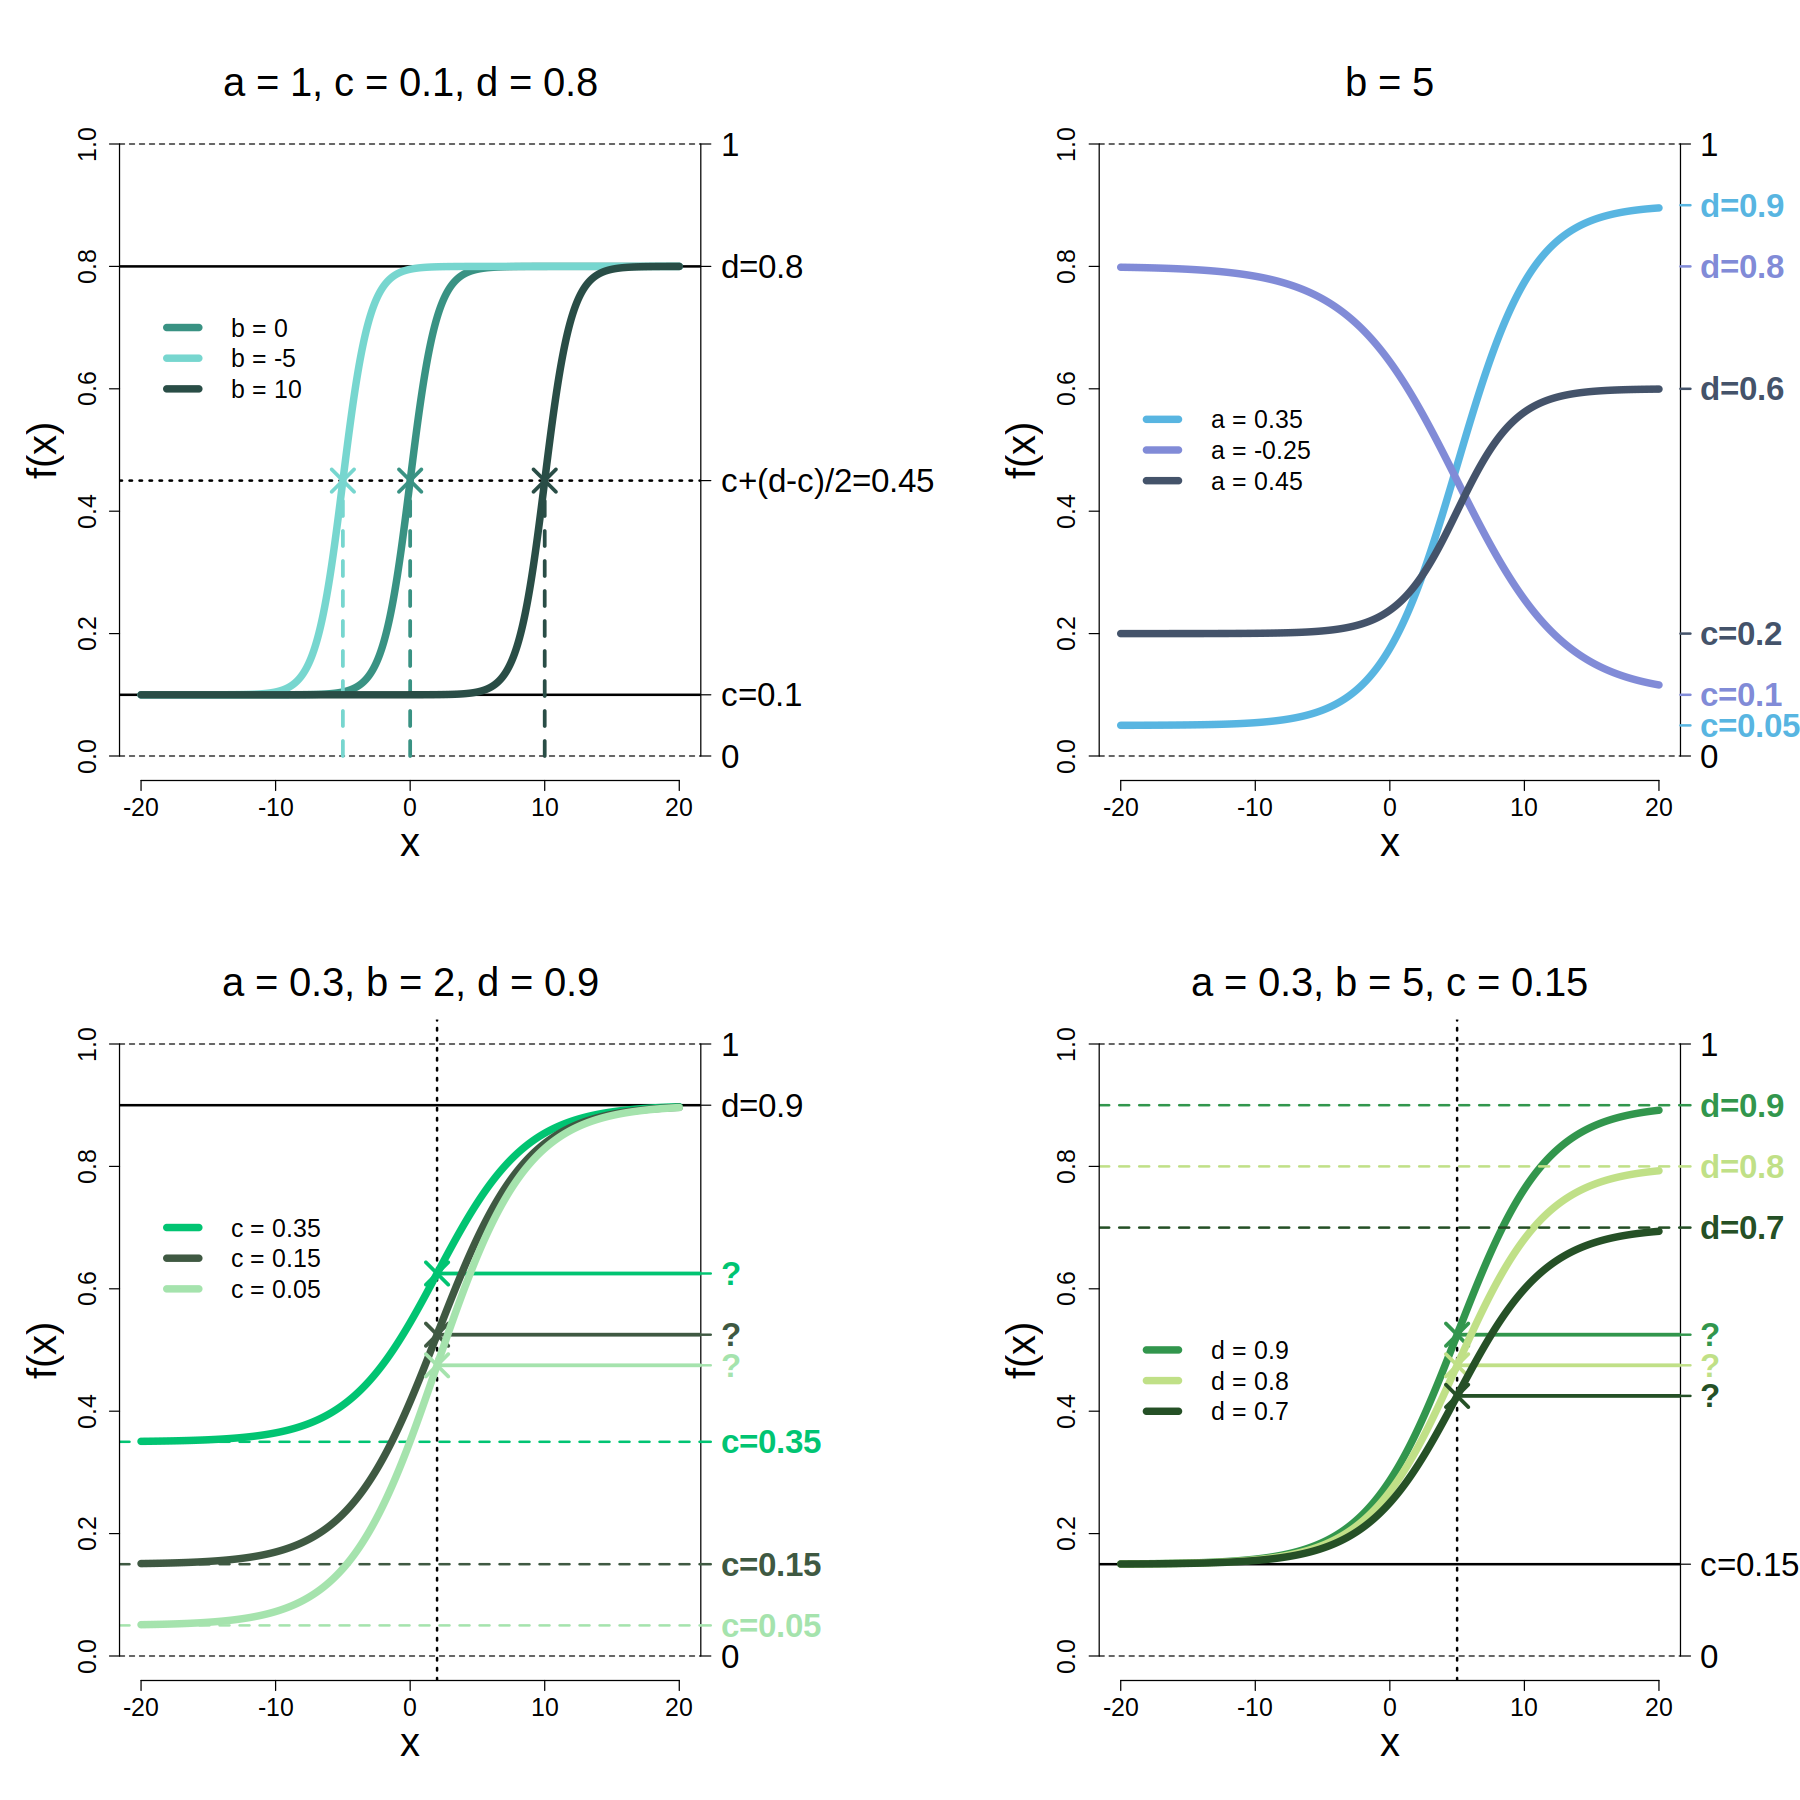

In [4]:
msqt <- read.csv('data/picaduras_mosquito.csv')

### Modelo Logístico
f_x <- function(x,a,b,c,d){
    return(c+(d-c)/(1+exp(-(a*(x-b)))))
}

options(repr.plot.width = 15, repr.plot.height = 15)
layout(matrix(1:4,ncol=2))
par(cex.axis=1.5,mar=rep(6,4))

x <- seq(-20,20,0.01)

# LEFT plots
par(mar=c(6,6,6,10))

# b variable:
plot(NULL,xlim=c(-20,20),ylim=c(0,1),ann=F,axes=F)
abline(h=c(0,1),lty='dashed')
cols <- c("#399283", "#77d6cf", "#294d46")
a <- 1
b <- c(0,-5,10)
c <- 0.1
d <- 0.8
abline(h=c(c,d),lwd=2)
abline(h=c(c+(d-c)/2),lwd=2,lty='dotted')
axis(4,at=c(0,1,c,d,c+(d-c)/2),labels=paste(c('','','c=','d=','c+(d-c)/2='),c(0,1,c,d,c+(d-c)/2),sep=''),
     las=1,cex.axis=2)
for(i in 1:length(b)){
    points(x=rep(b[i],2),y=c(0,c+(d-c)/2),
           lty='dashed',col=cols[i],type='o',lwd=3,
          pch=c(NA,4),cex=3)
    lines(x,f_x(x,a=a,b[i],c=c,d=d),col=cols[i],lwd=6)
}
legend(-30,.65,yjust=0.5,legend=paste('b =',b),
       lwd=6,col=cols,seg.len=.2,x.intersp=.2,y.intersp=.25,
       text.width = 2,cex=1.5,box.lty='blank',bg=NA)
axis(1);axis(2)
mtext(paste('a = ',a,', c = ',c,', d = ',d,sep=''),cex=2,line=1)
mtext('x',1,cex=2,line=3)
mtext('f(x)',2,cex=2,line=3)


# c variable:
plot(NULL,xlim=c(-20,20),ylim=c(0,1),ann=F,axes=F)
abline(h=c(0,1),lty='dashed')
cols <- c("#01c472", "#3f5942", "#a5e3ad")
a <- .3
b <- 2
c <- c(.35,.15,.05)
d <- 0.9
abline(h=d,lwd=2)
abline(v=b,lwd=2,lty='dotted')
axis(4,at=c(0,1,d),labels=paste(c('','','d='),c(0,1,d),sep=''),
     las=1,cex.axis=2)
for(i in 1:length(c)){
    abline(h=c[i],lwd=2,lty='dashed',col=cols[i])
    points(x=c(b,30),y=rep(c[i]+(d-c[i])/2,2),
           lwd=3,col=cols[i],type='o',
          pch=c(4,NA),cex=3)
    lines(x,f_x(x,a=a,b,c=c[i],d=d),col=cols[i],lwd=6)
    axis(4,at=c(c[i],c[i]+(d-c[i])/2),
         labels=c(paste('c=',c[i],sep=''),'?'),
         las=1,cex.axis=2,lwd=0,lwd.ticks=2,
         col.ticks=cols[i],col.axis=cols[i],
        font=2)
}
legend(-30,.65,yjust=0.5,legend=paste('c =',c),
       lwd=6,col=cols,seg.len=.2,x.intersp=.2,y.intersp=.25,
       text.width = 2,cex=1.5,box.lty='blank',bg=NA)
axis(1);axis(2)
mtext(paste('a = ',a,', b = ',b,', d = ',d,sep=''),cex=2,line=1)
mtext('x',1,cex=2,line=3)
mtext('f(x)',2,cex=2,line=3)

# RIGHT plots
par(mar=c(6,10,6,6))

# c y d variables:
plot(NULL,xlim=c(-20,20),ylim=c(0,1),ann=F,axes=F)
abline(h=c(0,1),lty='dashed')
cols <- c("#58b5e1", "#818bd7", "#44536a")
a <- c(.35,-.25,.45)
b <- 5
c <- c(.05,.1,.2)
d <- c(0.9,0.8,0.6)
axis(4,at=c(0,1),las=1,cex.axis=2)
for(i in 1:length(c)){
    lines(x,f_x(x,a=a[i],b,c=c[i],d=d[i]),col=cols[i],lwd=6)
        axis(4,at=c(c[i],d[i]),
         labels=c(paste('c=',c[i],sep=''),paste('d=',d[i],sep='')),
         las=1,cex.axis=2,lwd=0,lwd.ticks=2,
         col.ticks=cols[i],col.axis=cols[i],
        font=2)
}
legend(-30,0.5,yjust=0.5,legend=paste('a =',a),
       lwd=6,col=cols,seg.len=.2,x.intersp=.2,y.intersp=.25,
       text.width = 2,cex=1.5,box.lty='blank',bg=NA)
axis(1);axis(2)
mtext(paste('b = ',b,sep=''),cex=2,line=1)
mtext('x',1,cex=2,line=3)
mtext('f(x)',2,cex=2,line=3)

# d variable:
plot(NULL,xlim=c(-20,20),ylim=c(0,1),ann=F,axes=F)
abline(h=c(0,1),lty='dashed')
cols <- c("#32964d", "#c0e087", "#255026")
a <- .3
b <- 5
c <- .15
d <- c(.9,0.8,0.7)
abline(h=c,lwd=2)
abline(v=b,lwd=2,lty='dotted')
axis(4,at=c(0,1,c),labels=paste(c('','','c='),c(0,1,c),sep=''),
     las=1,cex.axis=2)
for(i in 1:length(d)){
    abline(h=d[i],lwd=2,lty='dashed',col=cols[i])
    points(x=c(b,30),y=rep(c+(d[i]-c)/2,2),
           lwd=3,col=cols[i],type='o',
          pch=c(4,NA),cex=3)
    lines(x,f_x(x,a=a,b,c=c,d=d[i]),col=cols[i],lwd=6)
    axis(4,at=c(d[i],c+(d[i]-c)/2),
         labels=c(paste('d=',d[i],sep=''),'?'),
         las=1,cex.axis=2,lwd=0,lwd.ticks=2,
         col.ticks=cols[i],col.axis=cols[i],
        font=2)
}
legend(-30,.45,yjust=0.5,legend=paste('d =',d),
       lwd=6,col=cols,seg.len=.2,x.intersp=.2,y.intersp=.25,
       text.width = 2,cex=1.5,box.lty='blank',bg=NA)
axis(1);axis(2)
mtext(paste('a = ',a,', b = ',b,', c = ',c,sep=''),cex=2,line=1)
mtext('x',1,cex=2,line=3)
mtext('f(x)',2,cex=2,line=3)


Podemos probar el modelo 4PL sobre los datos de `picaduras_mosquito.csv` para comparar su desempeño respecto del modelo anterior. Para hacerlo, aparte de la ojiva logística, necesitamos especificar la incertidumbre inicial sobre los parámetros de la misma:

$$a\sim Gaussian(\mu=0,\sigma=1)$$

$$b\sim Gaussian(\mu=50,\sigma=10)$$

$$c\sim Uniform(0,0.4)$$

$$d\sim Uniform(0.6,1)$$


$$\theta_{y_{i}}|a, b, c, d, x_i\leftarrow c+(d-c)\frac{1}{1+e^{-a(x_{i}-b)}}$$

$$y_i|\theta_{y_{i}}\sim Bernoulli(\theta_{y_{i}})$$

In [5]:
# Observed 
y <- msqt$mosquito
x <- msqt$edad

n_obs <- length(x)
data_jags <- list('x','y','n_obs')

# Unobserved
unobs <- c('a_post','a_prior',
          'b_post','b_prior',
           'c_post','c_prior',
          'd_post','d_prior',
           'theta_y_post','theta_y_prior',
          'y_postdict_post','y_postdict_prior')

# Model
write('model{

a_post~dnorm(0,1)
a_prior~dnorm(0,1)
b_post~dnorm(50,.01)
b_prior~dnorm(50,.01)
c_post~dunif(0,0.4)
c_prior~dunif(0,0.4)
d_post~dunif(0.6,1)
d_prior~dunif(0.6,1)

for(i in 1:n_obs){
    theta_y_post[i] <- c_post+(d_post-c_post)/(1+exp(-a_post*(x[i]-b_post)))
    theta_y_prior[i] <- c_prior+(d_prior-c_prior)/(1+exp(-a_prior*(x[i]-b_prior)))
    y[i]~dbern(theta_y_post[i])
    y_postdict_post[i]~dbern(theta_y_post[i])
    y_postdict_prior[i]~dbern(theta_y_prior[i])
}

}
','four_parameter_logistic_regression.bug')

library('R2jags')
set.seed(18)
bayes <- jags(data=data_jags,
             parameters.to.save=unobs,
             model.file='four_parameter_logistic_regression.bug',
             n.chains=3,
             n.iter=15000,
             n.burnin=5000,
             n.thin=5)
nds_4pl <- bayes$BUGSoutput$sims.list
summary(bayes$BUGSoutput$summary[,'Rhat'])

Loading required package: rjags

Loading required package: coda

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs


Attaching package: ‘R2jags’


The following object is masked from ‘package:coda’:

    traceplot


module glm loaded



Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 377
   Unobserved stochastic nodes: 762
   Total graph size: 5091

Initializing model



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.001   1.001   1.001   1.001   1.001   1.005 

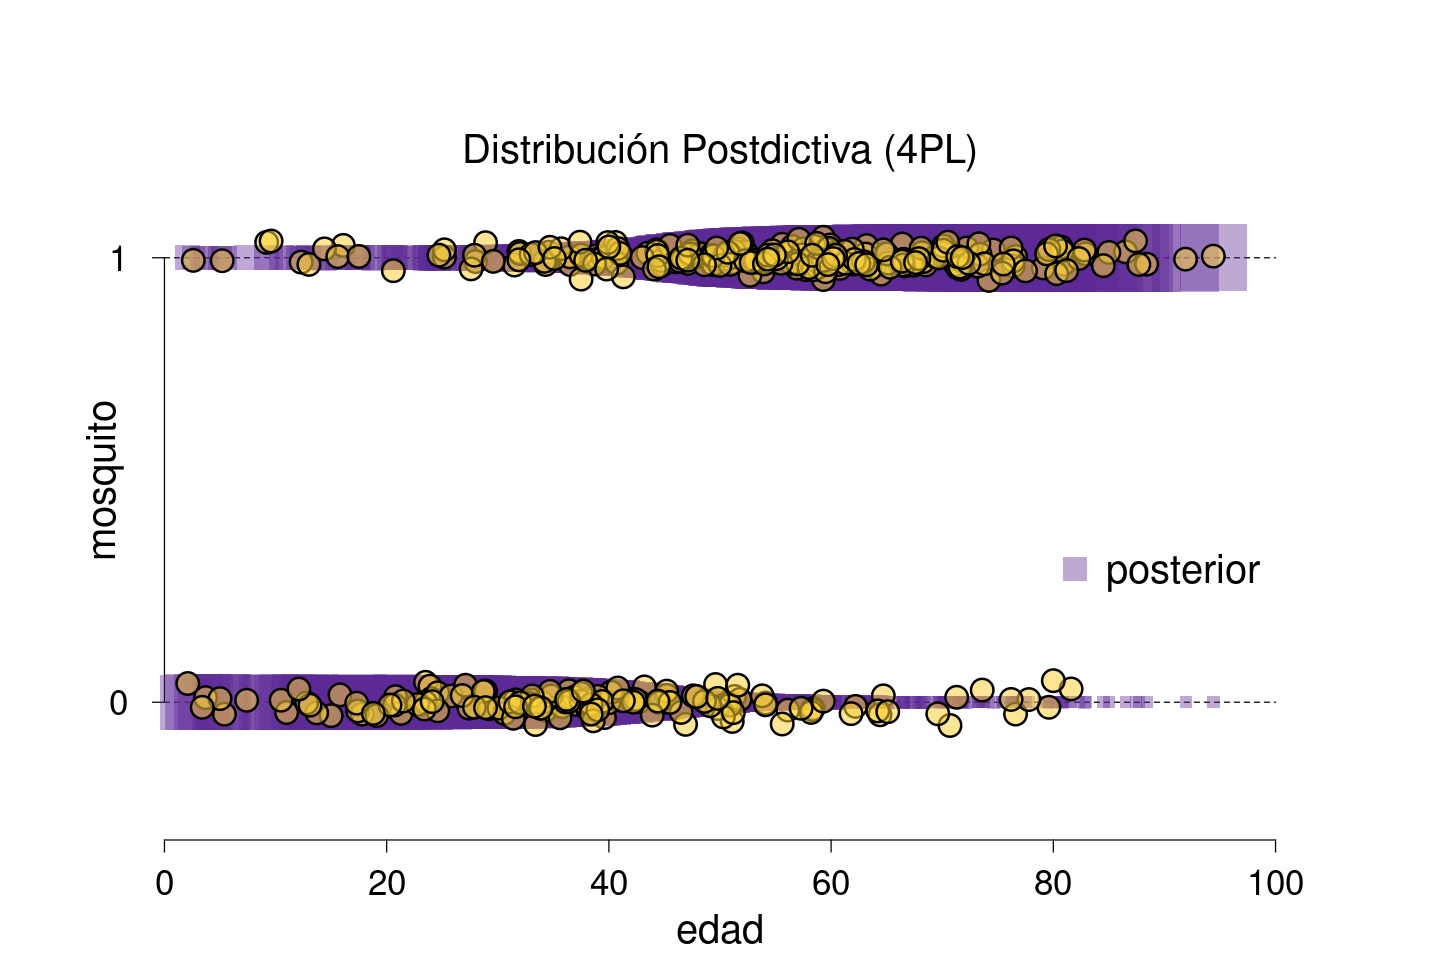

In [20]:
col_prior <- '#daa4f9'
col_post <- '#5e2a96'

options(repr.plot.width = 12, repr.plot.height = 8)
par(cex.axis=1.75,mgp=c(2,1.5,0),mar=rep(5,4))
plot(NULL,xlim=c(0,100),ylim=c(-.25,1.25),axes=F,ann=F)
segments(x0=rep(0,2),x1=rep(100,2),y0=c(0,1),y1=c(0,1),lty='dashed')
axis(1)
axis(2,at=c(0,1),las=1,pos=0)
mtext('edad',1,cex=2,line=3.5)
mtext('mosquito',2,cex=2,line=0)
mtext('Distribución Postdictiva (4PL)',3,cex=2,line=-2)
# Observation to highlight:
highlight <- 1:length(msqt$edad)
for(h in highlight){
    postdiction <- nds_4pl$y_postdict_post[,h] # Prediciton comes from 4PL *guaranteed*!
    post_1 <- sum(postdiction)/length(postdiction)
    post_0 <- 1-post_1
    points(x=rep(msqt$edad[h],2),y=c(0,1),cex=c(post_0,post_1)*10,
           pch=22,bg=paste(col_post,'66',sep=''),col=NA)
}

legend(75,0.3,yjust=0.5,pt.cex=3,
       pch=22,pt.bg=paste(col_post,'66',sep=''),
       col=NA,legend=,'posterior',
       seg.len=.3,cex=2,x.intersp=.4,text.width=3,box.lty='blank',bg='#ffffff88')

points(msqt$edad,msqt$mosquito+jitter,cex=2.5,pch=21,bg=paste(col_data,'88',sep=''),lwd=2)

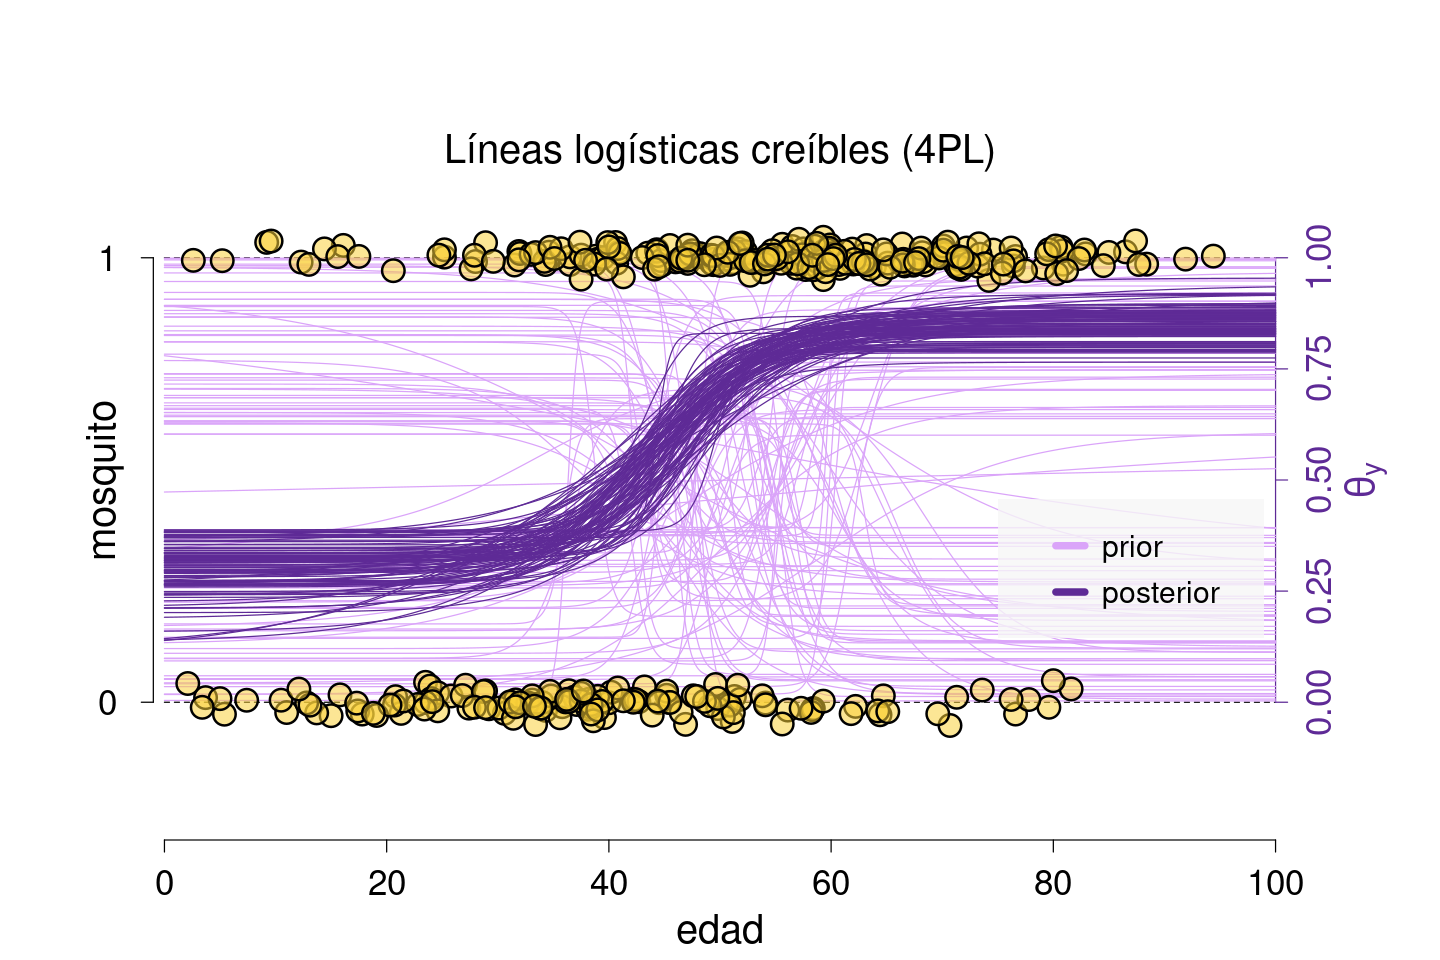

In [21]:
# Relaciones Logísticas Creíbles

options(repr.plot.width = 12, repr.plot.height = 8)
par(cex.axis=1.75,mgp=c(2,1.5,0),mar=rep(5,4))
plot(NULL,xlim=c(0,100),ylim=c(-.25,1.25),axes=F,ann=F)
segments(x0=rep(0,2),x1=rep(100,2),y0=c(0,1),y1=c(0,1),lty='dashed')
axis(1)
axis(2,at=c(0,1),las=1,pos=-1)
mtext('edad',1,cex=2,line=3.5)
mtext('mosquito',2,cex=2,line=0)
mtext('Líneas logísticas creíbles (4PL)',3,cex=2,line=-2)
axis(4,at=seq(0,1,.25),pos=100,col.axis=col_post,col=col_post)
mtext(expression('\u03b8'[y]),4,cex=2,line=2,col=col_post)
# indexes in JAGS to plot:
index <- sample(1:dim(nds_4pl$a_post)[1],size=100)
x_plot <- seq(0,100,0.01)
for(i in index){
    a_prior <- nds_4pl$a_prior[i] # 'nds_4pl' makes things readable as well!
    b_prior <- nds_4pl$b_prior[i]
    c_prior <- nds_4pl$c_prior[i]
    d_prior <- nds_4pl$d_prior[i]
    p_y_prior <- c_prior+(d_prior-c_prior)/(1+exp(-a_prior*(x_plot-b_prior)))
    lines(x_plot,p_y_prior,col=col_prior)
}
for(i in index){
    a_post <- nds_4pl$a_post[i]
    b_post <- nds_4pl$b_post[i]
    c_post <- nds_4pl$c_post[i]
    d_post <- nds_4pl$d_post[i]
    p_y_post <- c_post+(d_post-c_post)/(1+exp(-a_post*(x_plot-b_post)))
    lines(x_plot,p_y_post,col=col_post)
}

legend(99,0.3,yjust=0.5,xjust=1,lwd=6,
       col=c(col_prior,col_post),legend=c('prior','posterior'),
       seg.len=.5,cex=1.5,x.intersp=.3,text.width=12,box.lty='blank',bg='#f6f6f6cc')

points(msqt$edad,msqt$mosquito+jitter,cex=2.5,pch=21,bg=paste(col_data,'88',sep=''),lwd=2)

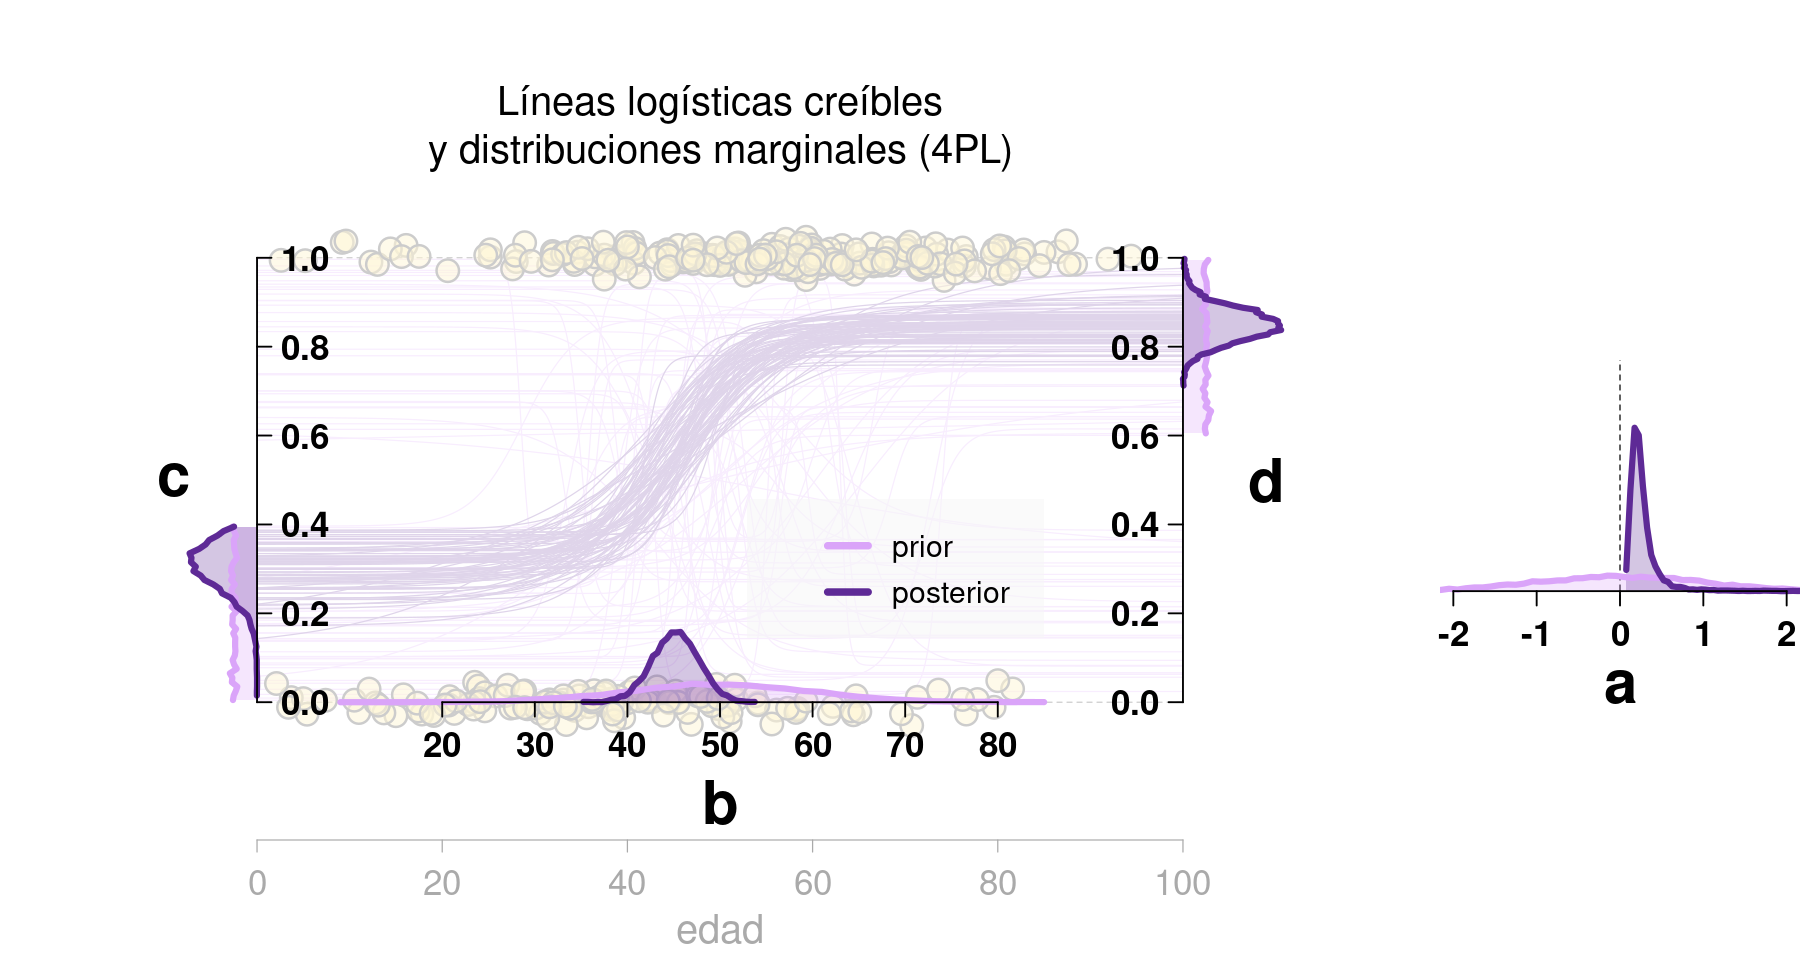

In [22]:
# Marginal Distributions

options(repr.plot.width = 15, repr.plot.height = 8)
layout(matrix(1:2,ncol=2),widths = c(4,1))
par(cex.axis=1.75,mgp=c(2,1.5,0),mar=rep(5,4))
plot(NULL,xlim=c(-10,110),ylim=c(-.25,1.25),axes=F,ann=F)
segments(x0=rep(0,2),x1=rep(100,2),y0=c(0,1),y1=c(0,1),lty='dashed')
axis(1,col='#aaaaaa',col.axis='#aaaaaa')
mtext('edad',1,cex=2,line=3.5,col='#aaaaaa')
mtext('Líneas logísticas creíbles\ny distribuciones marginales (4PL)',3,cex=2,line=-2)
# indexes in JAGS to plot:
index <- sample(1:dim(nds_4pl$a_post)[1],size=80)
x_plot <- seq(0,100,0.01)
for(i in index){
    a_prior <- nds_4pl$a_prior[i] # 'nds_4pl' makes things readable as well!
    b_prior <- nds_4pl$b_prior[i]
    c_prior <- nds_4pl$c_prior[i]
    d_prior <- nds_4pl$d_prior[i]
    p_y_prior <- c_prior+(d_prior-c_prior)/(1+exp(-a_prior*(x_plot-b_prior)))
    lines(x_plot,p_y_prior,col=col_prior)
}
for(i in index){
    a_post <- nds_4pl$a_post[i]
    b_post <- nds_4pl$b_post[i]
    c_post <- nds_4pl$c_post[i]
    d_post <- nds_4pl$d_post[i]
    p_y_post <- c_post+(d_post-c_post)/(1+exp(-a_post*(x_plot-b_post)))
    lines(x_plot,p_y_post,col=col_post)
}

points(msqt$edad,msqt$mosquito+jitter,cex=2.5,pch=21,bg=paste(col_data,'88',sep=''),lwd=2)
polygon(x=c(-10,110,110,-10),y=c(-.25,-.25,1.15,1.15),col='#ffffffcc',border=NA)

# Uncertainty over b
b_pst <- hist(nds_4pl$b_post,breaks=50,plot=F)
b_prr <- hist(nds_4pl$b_prior,breaks=50,plot=F)
prr_dens <- b_prr$density
prr_mids <- b_prr$mids
pst_dens <- b_pst$density
pst_mids <- b_pst$mids
polygon(x=c(head(prr_mids,1),prr_mids,tail(prr_mids,1)),y=c(0,prr_dens,0),
        col=paste(col_prior,'44',sep=''),border=NA)
polygon(x=c(head(pst_mids,1),pst_mids,tail(pst_mids,1)),y=c(0,pst_dens,0),
        col=paste(col_post,'44',sep=''),border=NA)
lines(prr_mids,prr_dens,lwd=5,col=col_prior)
lines(pst_mids,pst_dens,lwd=5,col=col_post)
text(50,-.225,'b',cex=3,font=2,srt=0)

# Uncertainty over c
c_pst <- hist(nds_4pl$c_post,breaks=50,plot=F)
c_prr <- hist(nds_4pl$c_prior,breaks=50,plot=F)
prr_dens <- -c_prr$density
prr_mids <- c_prr$mids
pst_dens <- -c_pst$density
pst_mids <- c_pst$mids
polygon(x=c(0,prr_dens,0),y=c(head(prr_mids,1),prr_mids,tail(prr_mids,1)),
        col=paste(col_prior,'44',sep=''),border=NA)
polygon(x=c(0,pst_dens,0),y=c(head(pst_mids,1),pst_mids,tail(pst_mids,1)),
        col=paste(col_post,'44',sep=''),border=NA)
lines(prr_dens,prr_mids,lwd=5,col=col_prior)
lines(pst_dens,pst_mids,lwd=5,col=col_post)
text(-9,.5,'c',cex=3,font=2,srt=0)

# Uncertainty over d
d_pst <- hist(nds_4pl$d_post,breaks=50,plot=F)
d_prr <- hist(nds_4pl$d_prior,breaks=50,plot=F)
prr_dens <- 100+d_prr$density
prr_mids <- d_prr$mids
pst_dens <- 100+d_pst$density
pst_mids <- d_pst$mids
polygon(x=c(100,prr_dens,100),y=c(head(prr_mids,1),prr_mids,tail(prr_mids,1)),
        col=paste(col_prior,'44',sep=''),border=NA)
polygon(x=c(100,pst_dens,100),y=c(head(pst_mids,1),pst_mids,tail(pst_mids,1)),
        col=paste(col_post,'44',sep=''),border=NA)
lines(prr_dens,prr_mids,lwd=5,col=col_prior)
lines(pst_dens,pst_mids,lwd=5,col=col_post)
text(109,.5,'d',cex=3,font=2,srt=0)

par(mgp=c(1,1.5,0))
axis(1,at=seq(20,80,10),pos=0,lwd=1.5,tck=-0.02,font=2)
par(mgp=c(-1,-3,0))
axis(2,at=seq(0,1,0.2),las=1,pos=0,lwd=1.5,tck=0.02,font=2)
axis(4,at=seq(0,1,0.2),las=1,pos=100,lwd=1.5,tck=0.02,font=2)

legend(85,0.3,yjust=0.5,xjust=1,lwd=6,
       col=c(col_prior,col_post),legend=c('prior','posterior'),
       seg.len=.5,cex=1.5,x.intersp=.3,text.width=12,box.lty='blank',bg='#f6f6f688')

# Uncertainty over a
par(mar=c(15,0,15,0))
plot(NULL,xlim=c(-2,2),ylim=c(0,6),axes=F,ann=F)
abline(v=0,lty='dashed')
a_pst <- hist(nds_4pl$a_post,breaks=50,plot=F)
a_prr <- hist(nds_4pl$a_prior,breaks=50,plot=F)
prr_dens <- a_prr$density
prr_mids <- a_prr$mids
pst_dens <- a_pst$density
pst_mids <- a_pst$mids
polygon(x=c(head(prr_mids,1),prr_mids,tail(prr_mids,1)),y=c(0,prr_dens,0),
        col=paste(col_prior,'44',sep=''),border=NA)
polygon(x=c(head(pst_mids,1),pst_mids,tail(pst_mids,1)),y=c(0,pst_dens,0),
        col=paste(col_post,'44',sep=''),border=NA)
lines(prr_mids,prr_dens,lwd=5,col=col_prior)
lines(pst_mids,pst_dens,lwd=5,col=col_post)
mtext('a',1,line=3.5,cex=3,font=2)
par(mgp=c(1,1.5,0))
axis(1,pos=0,lwd=1.5,tck=-0.06,font=2)

### Ejercicio: Driving Under the Influence

La base `DUI.csv` cotiene información de `514` personas registrada en una zona de bares de la ciudad. Medimos dos variables: la `concentración de alcohol` en sangre, y si tienen un `accidente en automóvil` manejando esa misma noche.

1. Lee la base y haz explícitos los descriptivos generales.

2. Grafica `accidente` como función de `alcohol` y decide si la exploración visual sugiere una relación entre ambas variables.

3. Implementa **los dos** modelos logísticos que hemos estudiado, utilizando esta incertidumbre inicial sobre la *tasa* $a$ y sobre el *punto medio* $b$:

$$a\sim Gaussian(\mu=0,\sigma=10)$$

$$b\sim Gaussian(\mu=0.50,\sigma=0.10),$$

agregando incertidumbre inicial apropiada para la asíntota inferior $c$ y para la superior $d$ en el modelo de 4 parámetros.

4. Asegúrate de que las cadenas de `JAGS` muestren convergencia para cada modelo.

5. Grafica la distribución postdictiva **completa** para **cada modelo**, y decide cuál de los dos explica mejor las observaciones. Argumenta tu respuesta.

6. El nivel de `alcohol en sangre` más elevando en la base es 0.70, pero podría interesarnos hacer predicciones sobre un nivel de alcohol mayor, aunque todavía no lo hayamos observado. Implementa esta predicción en ambos modelos y haz explícito el resultado: ¿qué tan probable es tener un `accidente` para una persona que tenga `alcohol=0.90`, de acuerdo con **cada** modelo?

### Epílogo

Algunas sesiones atrás revisamos un ejemplo sobre retención de memoria en el que tres participantes intentan recordar 18 palabras de una lista después de diferentes intervalos de tiempo (Lee & Wagenmakers, 2013, Capítulo 10; Shiffrin et al., 2008). La idea central del modelo era que la probabilidad de recordar cada palabra disminuye conforme el tiempo transcurre, de acuerdo con cierta función presentada como "modelo de decaimiento exponencial". 

En tanto que dicha ecuación relaciona cierta probabilidad $\in(0,1)$ como función de cierta variable $\in\mathbb{R}$, es posible sustituirla por cualquiera de los modelos logísticos presentados en las secciones anteriores.
 
En las células siguientes mostramos cómo implementar dicho cambio, enfatizando las diferencias resultantes en la distribución postdictiva de cada función, y apuntando hacia las diferencias en la interpretación de cada modelo.


#### Referencias

Lee, M. D. & Wagenmakers, E.-J. (2013). _Bayesian Cognitive Modeling. A practical course_. Cambridge University Press.

Shiffrin, R. M., Lee, M. D., Kim, W. & Wagenmakers, E.-J. (2008). A survey of model evaluation approaches with a tutorial on hierarchical Bayesian methods. _Cognitive Science, 32,_ 1248:1284. https://doi.org/10.1080/03640210802414826

In [6]:
rm(list=ls())

# Observed
n_targets <- 18 # Number of words presented to participants
time <- c(1,2,4,7,12,21,35,59,99,200) # Time lags after which participants recall
n_times <- length(time) # Number of time lags
n_subjs <- 4 # Number of subject

n_recalled <- array(dim=c(n_subjs,n_times)) # Number of words recalled by each participant after each lag
n_recalled[1,] <- c(18,18,16,13,9,6,4,4,4,NA)
n_recalled[2,] <- c(17,13,9,6,4,4,4,4,4,NA)
n_recalled[3,] <- c(14,10,6,4,4,4,4,4,4,NA)
n_recalled[4,] <- NA

data_jags <- list('n_targets','time','n_times','n_subjs','n_recalled') # Everything is going to JAGS

# Unobserved (in this example these labels are consistent across models)
unobs <- c('mu_a_post','mu_a_prior',
          'lambda_a_post','lambda_a_prior',
          'mu_b_post','mu_b_prior',
          'lambda_b_post','lambda_b_prior',
          'alpha_c_prior','alpha_c_post',
          'beta_c_prior','beta_c_post',
          'alpha_d_prior','alpha_d_post',
          'beta_d_prior','beta_d_post',
          'a_post','a_prior',
          'b_post','b_prior',
          'c_post','c_prior',
          'd_post','d_prior',
          'theta_prior','theta_post',
          'n_recalled_prior','n_recalled_post')

# Logistic Curve + Hierarchical Individual Differences
write('

model{
  
  # Parents of Logistic Slopes 
  mu_a_post~dnorm(0,.1)
  mu_a_prior~dnorm(0,.1)
  lambda_a_post~dgamma(0.001,0.001)T(0.01,)
  lambda_a_prior~dgamma(0.001,0.001)T(0.01,)
    
  # Parents of Logistic Mid-Points Baseline
  mu_b_post~dnorm(50,.01)
  mu_b_prior~dnorm(50,.01)
  lambda_b_post~dgamma(0.001,0.001)T(0.01,)
  lambda_b_prior~dgamma(0.001,0.001)T(0.01,)

  # Parents of Logistic Lower Asymptote
  alpha_c_prior~dnorm(0,1)T(0.8,)
  alpha_c_post~dnorm(0,1)T(0.8,)
  beta_c_prior~dnorm(0,1)T(0.8,)
  beta_c_post~dnorm(0,1)T(0.8,)


  # Parents of Logistic Upper Asymptote
  alpha_d_prior~dnorm(0,1)T(0.8,)
  alpha_d_post~dnorm(0,1)T(0.8,)
  beta_d_prior~dnorm(0,1)T(0.8,)
  beta_d_post~dnorm(0,1)T(0.8,)
  
  for(i in 1:n_subjs){
    a_prior[i]~dnorm(mu_a_prior,lambda_a_prior)
    a_post[i]~dnorm(mu_a_post,lambda_a_post)
    b_prior[i]~dnorm(mu_b_prior,lambda_b_prior)
    b_post[i]~dnorm(mu_b_post,lambda_b_post)
    c_prior[i]~dbeta(alpha_c_prior,beta_c_prior)T(0,0.5)
    c_post[i]~dbeta(alpha_c_post,beta_c_post)T(0,0.5)
    d_prior[i]~dbeta(alpha_d_prior,beta_d_prior)T(0.5,1)
    d_post[i]~dbeta(alpha_d_post,beta_d_post)T(0.5,1)
    
    for(j in 1:n_times){
      theta_prior[i,j] <- c_prior[i]+(d_prior[i]-c_prior[i])*(1/(1+exp(-a_prior[i]*(time[j]-b_prior[i]))))
      theta_post[i,j] <- c_post[i]+(d_post[i]-c_post[i])*(1/(1+exp(-a_post[i]*(time[j]-b_post[i]))))
      n_recalled_prior[i,j]~dbin(theta_prior[i,j],n_targets)
      n_recalled[i,j]~dbin(theta_post[i,j],n_targets)
      n_recalled_post[i,j]~dbin(theta_post[i,j],n_targets)
    }
  }
  
}
','logistic_memory.bug')

# Inference over Model 3
library('R2jags')
bayes_logistic <- jags(data=data_jags,
                       parameters.to.save=unobs,
                       model.file='logistic_memory.bug',
                       n.iter=50000,
                       n.burnin=20000,
                       n.thin=3)
nds_logistic <- bayes_logistic$BUGSoutput$sims.list
summary(bayes_logistic$BUGSoutput$summary[,'Rhat'])

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 27
   Unobserved stochastic nodes: 141
   Total graph size: 765

Initializing model



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.001   1.001   1.001   1.001   1.001   1.036 

In [8]:
which(bayes_logistic$BUGSoutput$summary[,'Rhat']>1.05)

named integer(0)

In [9]:
# Unobserved (in this example these labels are consistent across models)
unobs <- c('alpha_post','beta_post','n_recalled_post',
           'alpha_prior','beta_prior','n_recalled_prior',
          'mu_alpha_prior','mu_alpha_post',
          'mu_beta_prior','mu_beta_post',
          'lambda_beta_prior','lambda_beta_post',
          'lambda_alpha_prior','lambda_alpha_post')

# Exponential Curve + Hierarchical Individual Differences
write('

model{
  
  # Parents of Decay Rate (alpha) 
  mu_alpha_post~dbeta(1,1)
  mu_alpha_prior~dbeta(1,1)
  lambda_alpha_post~dgamma(0.001,0.001)T(0.01,)
  lambda_alpha_prior~dgamma(0.001,0.001)T(0.01,)
    
  # Parents of Baseline (beta)
  mu_beta_post~dbeta(1,1)
  mu_beta_prior~dbeta(1,1)
  lambda_beta_post~dgamma(0.001,0.001)T(0.01,)
  lambda_beta_prior~dgamma(0.001,0.001)T(0.01,)
  
  for(i in 1:n_subjs){
    alpha_prior[i]~dnorm(mu_alpha_prior,lambda_alpha_prior)T(0,1)
    alpha_post[i]~dnorm(mu_alpha_post,lambda_alpha_post)T(0,1)
    beta_prior[i]~dnorm(mu_beta_prior,lambda_beta_prior)T(0,1)
    beta_post[i]~dnorm(mu_beta_post,lambda_beta_post)T(0,1)
    
    for(j in 1:n_times){
      theta_prior[i,j] <- min(.99,exp(-alpha_prior[i]*time[j])+beta_prior[i])
      theta_post[i,j] <- min(.99,exp(-alpha_post[i]*time[j])+beta_post[i])

      n_recalled_prior[i,j]~dbin(theta_prior[i,j],n_targets)
      n_recalled[i,j]~dbin(theta_post[i,j],n_targets)
      n_recalled_post[i,j]~dbin(theta_post[i,j],n_targets)
    }
  }
  
}
','exponential_memory.bug')

# Inference over Model 3
bayes_exponential <- jags(data=data_jags,
                       parameters.to.save=unobs,
                       model.file='exponential_memory.bug',
                       n.iter=100000,
                       n.burnin=1000,
                       n.thin=2)
nds_exponential <- bayes_exponential$BUGSoutput$sims.list
summary(bayes_exponential$BUGSoutput$summary[,'Rhat'])

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 27
   Unobserved stochastic nodes: 117
   Total graph size: 490

Initializing model



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.001   1.001   1.001   1.001   1.001   1.023 

In [10]:
which(bayes_exponential$BUGSoutput$summary[,'Rhat']>1.05)

named integer(0)

In [11]:
plot_postdiction <- function(nds,main_label){
  
  #nds <- nds_logistic
  
  par_cols <- c("#f8ba7c", "#fb7810","#df9f38","#974810")
  
  # Predictive Distributions
  options(repr.plot.width = 13, repr.plot.height = 13) # Plot size in notebook
  layout(matrix(1:4,ncol=2,byrow = T))
  par(oma=c(0,0,4,0))
  
  for(subj in 1:4){
    plot(NULL,xlim=c(0,n_times),ylim=c(0,n_targets+2),axes=F,ann=F)
    axis(1,at=1:n_times,labels=time,padj=0.25,cex.axis=1.5)
    axis(2,at=c(0,18),las=1,cex.axis=1.5)
    mtext('Time Lags',1,line=3,cex=1.5)
    mtext('Retention Count',2,line=1.5,cex=1.5)
    mtext(paste('Participant',subj),3,line=-1,cex=2)
    data_size <- NULL
    for(t in 1:n_times){
      hist(nds$n_recalled_post[,subj,t],breaks=seq(-.5,n_targets+.5,1),plot=F)->ht
      #hist(nds$n_recalled_prior[,subj,t],breaks=seq(-.5,n_targets+.5,1),plot=F)->ht
      point_size <- ht$density*18
      points(rep(t,n_targets+1),ht$mids,cex=point_size,pch=22,bg=paste(par_cols[subj],'66',sep=''))
      data_size <- append(data_size,point_size[which(0:n_targets==n_recalled[subj,t])])
    }
    lines(1:n_times,n_recalled[subj,],cex=data_size,type='o',bg=par_cols[subj],pch=22,lwd=4)
    
    # Adds legend exclusively in first plot
    if(subj==1){
      legend(6,19,
             legend=c('observed','predicted'),
             lty=c('solid','blank'),
             lwd=c(3,1),
             pt.bg=c(par_cols[subj],paste(par_cols[subj],'66',sep='')),
             pch=22,
             pt.cex=3.5,
             text.width=2.5,
             y.intersp=.4,
             x.intersp=.5,
             cex=1.5,
             box.lty='blank')
    }
  }
  
  mtext(main_label,3,outer=T,cex=2,font=2)
  
}

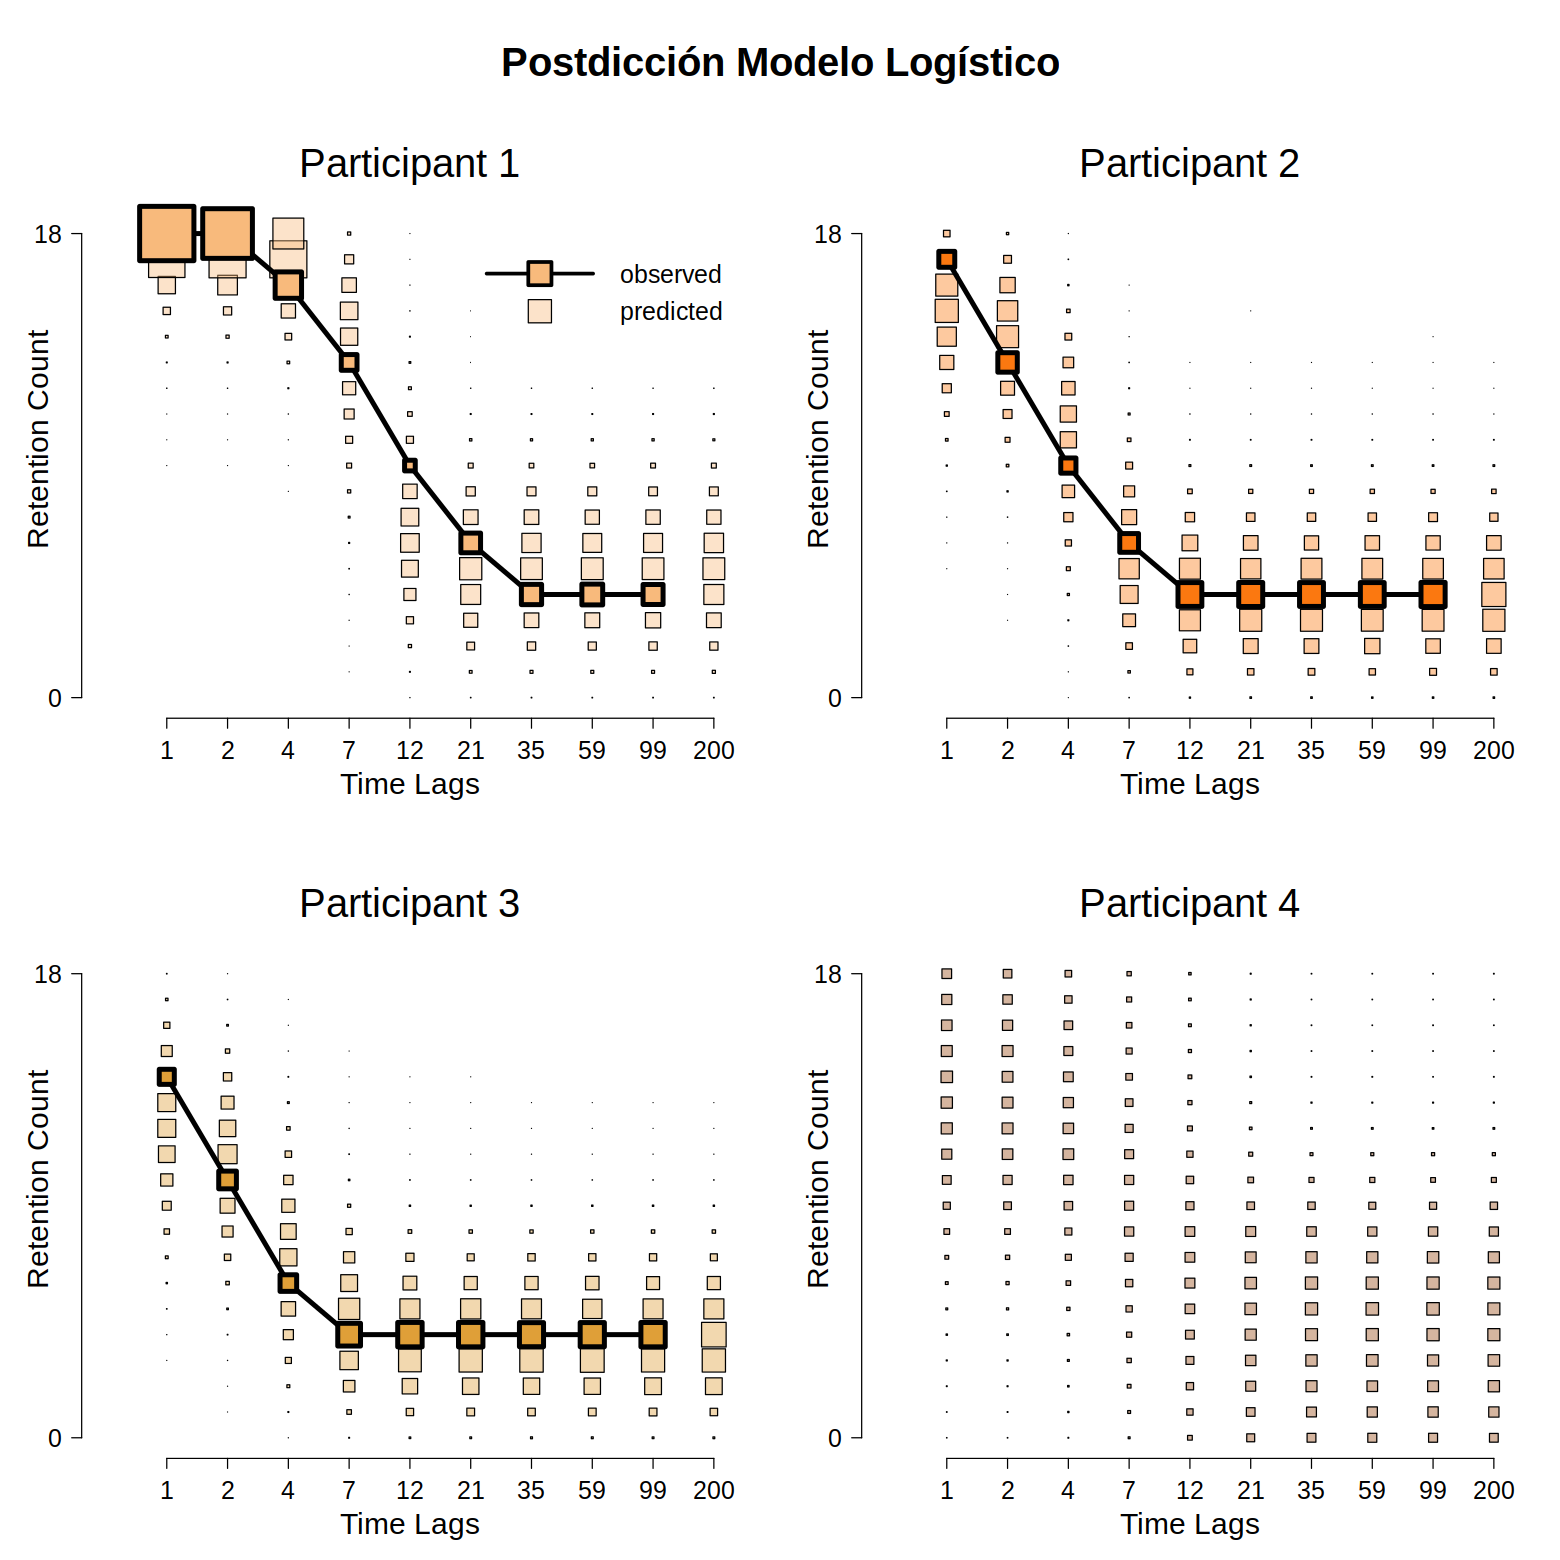

In [12]:
plot_postdiction(nds_logistic,'Postdicción Modelo Logístico')

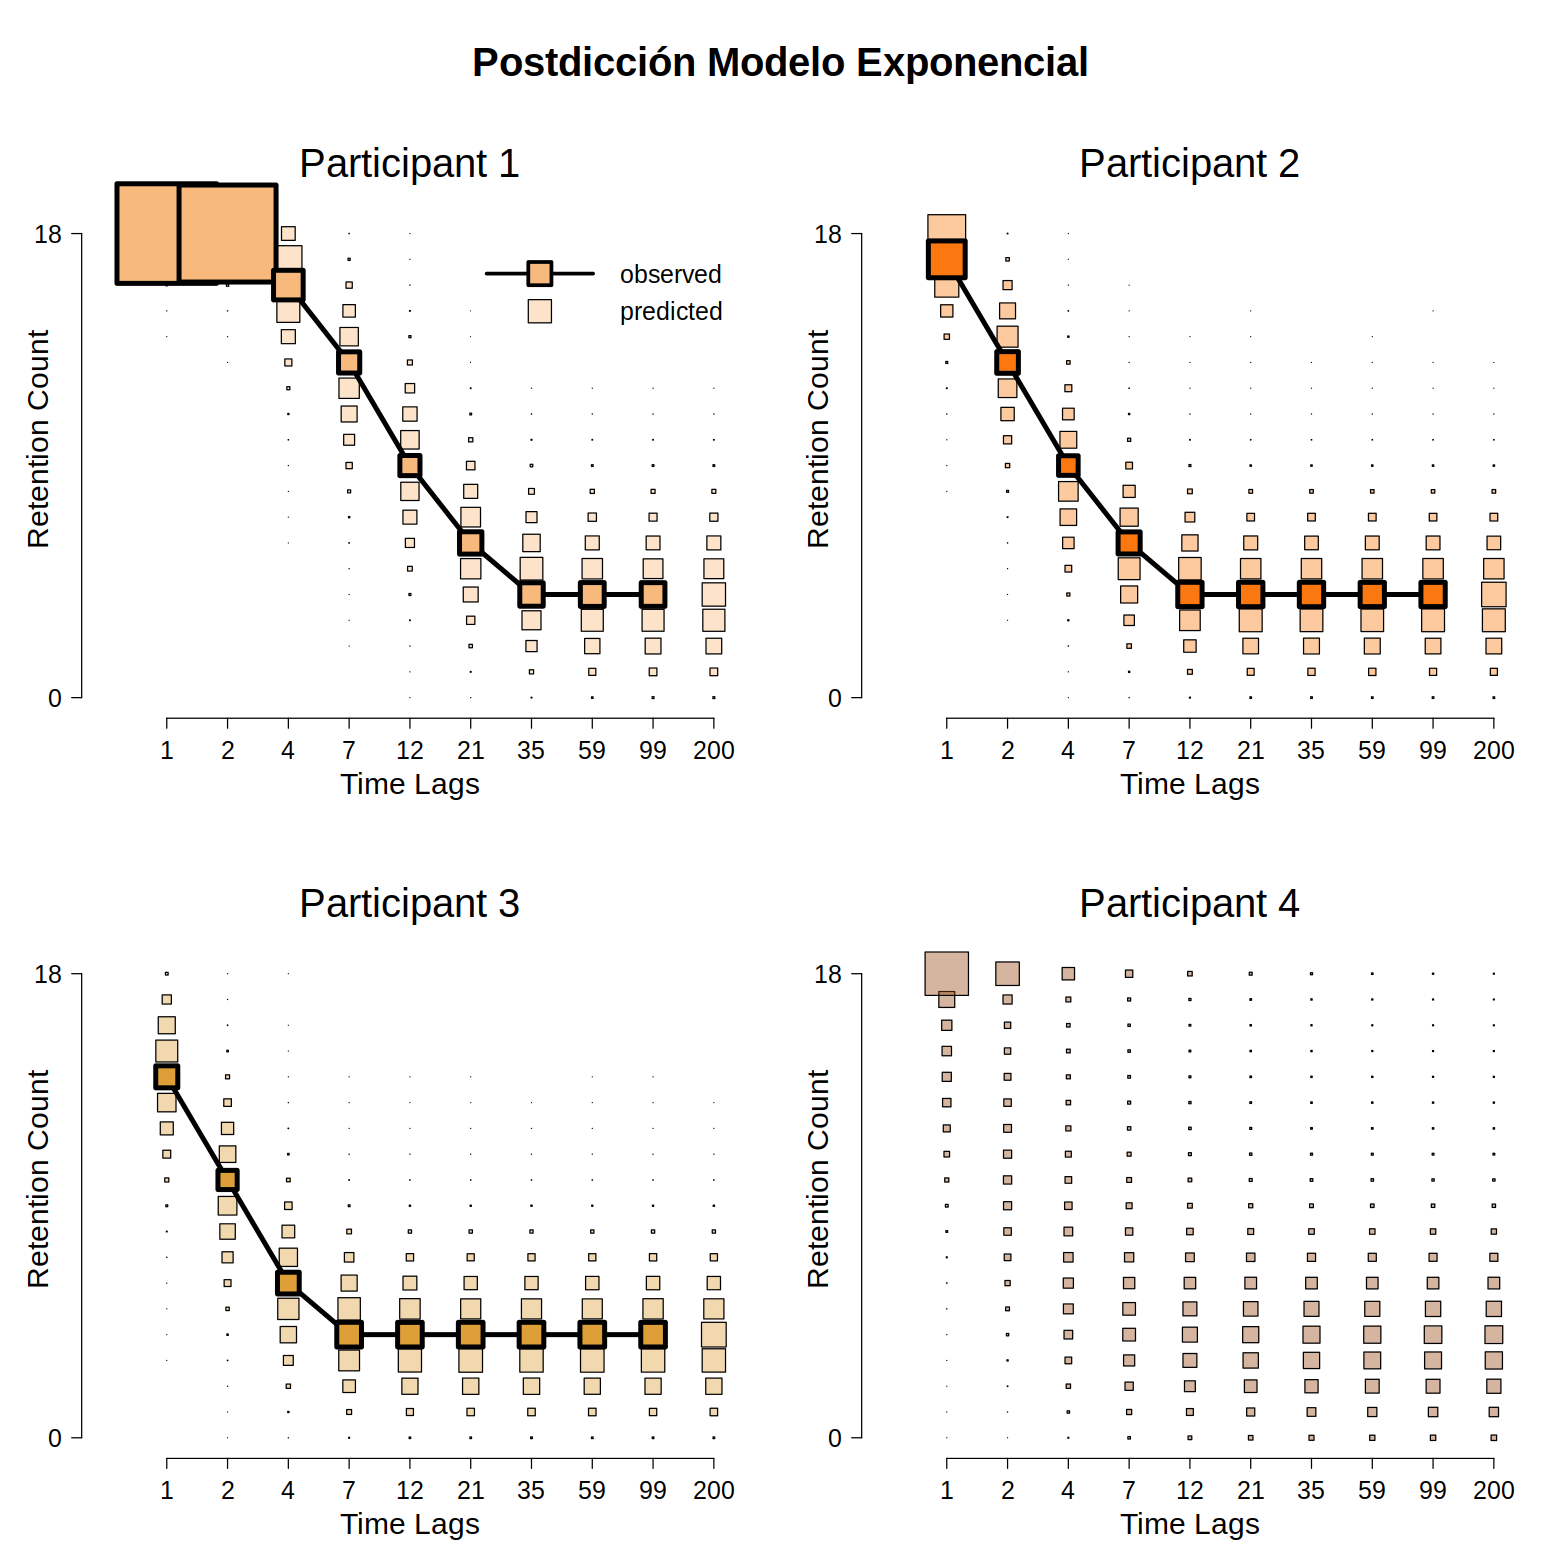

In [13]:
plot_postdiction(nds_exponential,'Postdicción Modelo Exponencial')

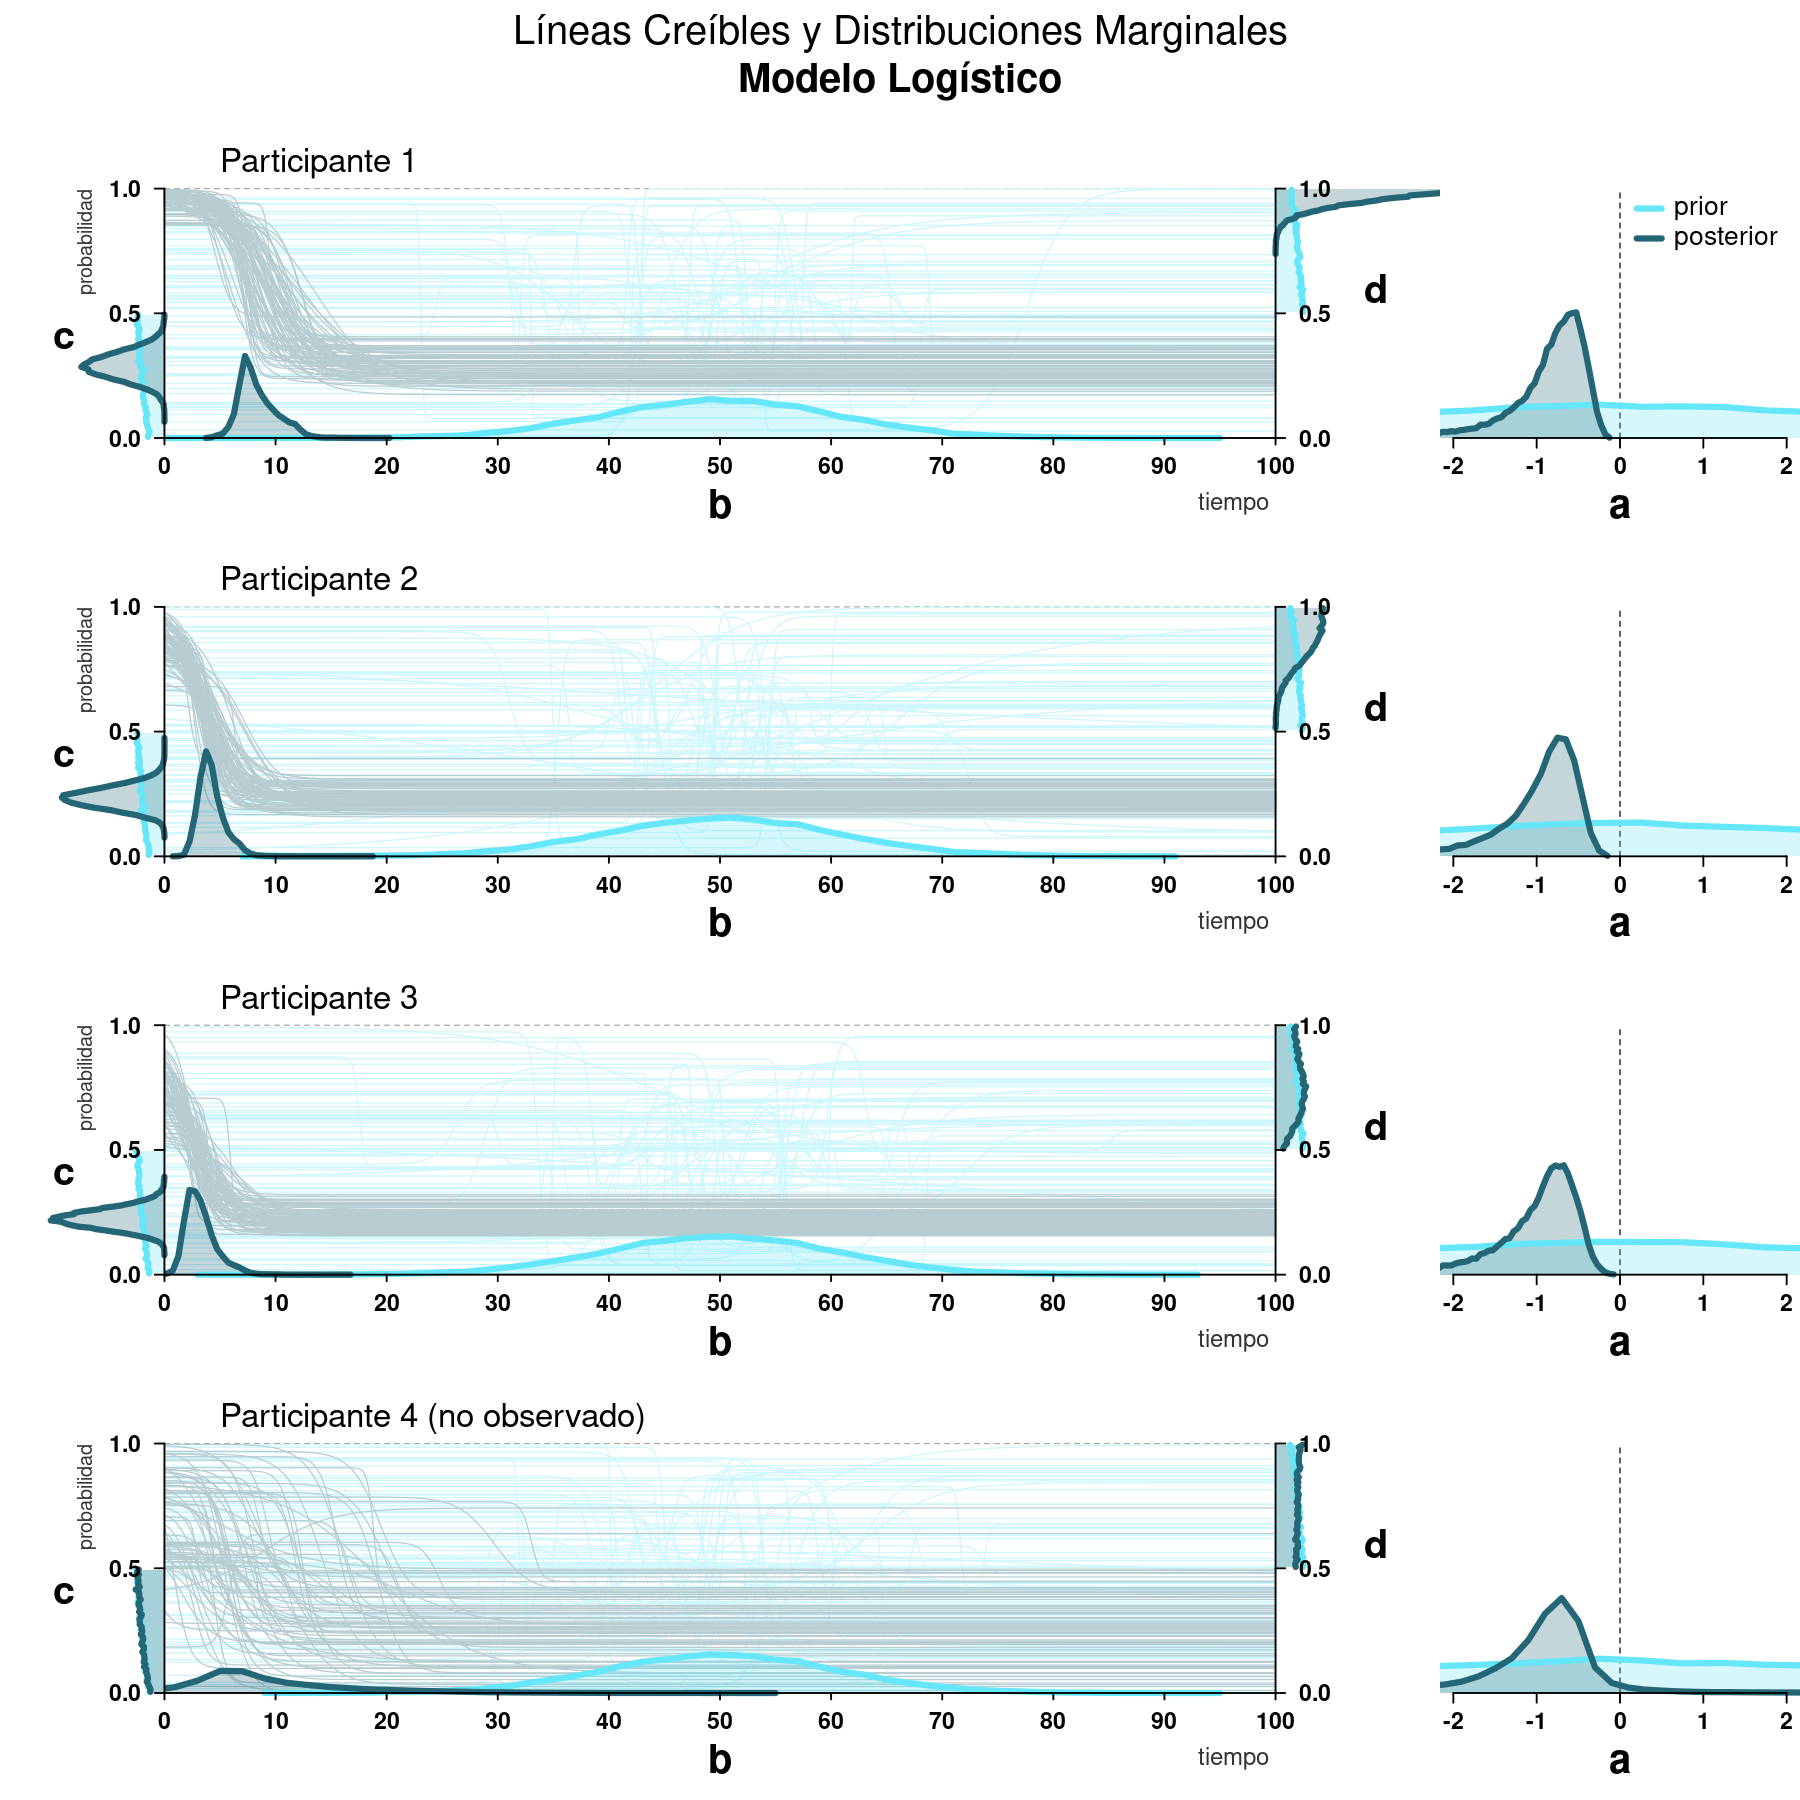

In [30]:
# Marginal Distributions LOGISTIC MODEL

col_prior <- '#65e6f9'
col_post <- '#256676'

options(repr.plot.width = 15, repr.plot.height = 15)
layout(matrix(1:8,ncol=2,byrow = T),widths = c(4,1))
par(cex.axis=1.75,mgp=c(2,1.5,0),mar=c(4,0,2,0),oma=c(2,0,6,0))

subj_labels <- paste('Participante',1:4,c(rep('',3),'(no observado)'))

for(subj in 1:4){
  
  plot(NULL,xlim=c(-10,110),ylim=c(0,1.2),axes=F,ann=F)
  segments(x0=rep(0,2),x1=rep(100,2),y0=c(0,1),y1=c(0,1),lty='dashed')
  
  # indexes in JAGS to plot:
  index <- sample(1:dim(nds_logistic$a_post)[1],size=80)
  x_plot <- seq(0,100,0.01)
  for(i in index){
    a_prior <- nds_logistic$a_prior[i,subj]
    b_prior <- nds_logistic$b_prior[i,subj]
    c_prior <- nds_logistic$c_prior[i,subj]
    d_prior <- nds_logistic$d_prior[i,subj]
    p_y_prior <- c_prior+(d_prior-c_prior)/(1+exp(-a_prior*(x_plot-b_prior)))
    lines(x_plot,p_y_prior,col=col_prior)
  }
  for(i in index){
    a_post <- nds_logistic$a_post[i,subj]
    b_post <- nds_logistic$b_post[i,subj]
    c_post <- nds_logistic$c_post[i,subj]
    d_post <- nds_logistic$d_post[i,subj]
    p_y_post <- c_post+(d_post-c_post)/(1+exp(-a_post*(x_plot-b_post)))
    lines(x_plot,p_y_post,col=col_post)
  }
  
  clip(0,100,-2,2)
  polygon(x=c(-10,110,110,-10),y=c(-.25,-.25,1.15,1.15),col='#ffffffaa',border=NA)
  text(5,1.1,subj_labels[subj],adj=0,cex=2.5)

  # Uncertainty over b
  b_pst <- hist(nds_logistic$b_post[,subj],breaks=50,plot=F)
  b_prr <- hist(nds_logistic$b_prior[,subj],breaks=50,plot=F)
  prr_dens <- b_prr$density*4
  prr_mids <- b_prr$mids
  pst_dens <- b_pst$density
  pst_mids <- b_pst$mids
  polygon(x=c(head(prr_mids,1),prr_mids,tail(prr_mids,1)),y=c(0,prr_dens,0),
          col=paste(col_prior,'44',sep=''),border=NA)
  polygon(x=c(head(pst_mids,1),pst_mids,tail(pst_mids,1)),y=c(0,pst_dens,0),
          col=paste(col_post,'44',sep=''),border=NA)
  lines(prr_mids,prr_dens,lwd=5,col=col_prior)
  lines(pst_mids,pst_dens,lwd=5,col=col_post)
  mtext('b',1,line=3.5,cex=2,font=2)
  
  clip(-100,200,-2,2)
  # Uncertainty over c
  c_pst <- hist(nds_logistic$c_post[,subj],breaks=50,plot=F)
  c_prr <- hist(nds_logistic$c_prior[,subj],breaks=50,plot=F)
  prr_dens <- -c_prr$density
  prr_mids <- c_prr$mids
  pst_dens <- -c_pst$density
  pst_mids <- c_pst$mids
  polygon(x=c(0,prr_dens,0),y=c(head(prr_mids,1),prr_mids,tail(prr_mids,1)),
          col=paste(col_prior,'44',sep=''),border=NA)
  polygon(x=c(0,pst_dens,0),y=c(head(pst_mids,1),pst_mids,tail(pst_mids,1)),
          col=paste(col_post,'44',sep=''),border=NA)
  lines(prr_dens,prr_mids,lwd=5,col=col_prior)
  lines(pst_dens,pst_mids,lwd=5,col=col_post)
  text(-9,.4,'c',cex=3,font=2,srt=0)
  text(-7,1,'probabilidad',srt=90,adj=1,cex=1.5,col='#333333')
  mtext('tiempo',1,line=3,adj=.875,cex=1.2,col='#333333')
  
  # Uncertainty over d
  d_pst <- hist(nds_logistic$d_post[,subj],breaks=50,plot=F)
  d_prr <- hist(nds_logistic$d_prior[,subj],breaks=50,plot=F)
  prr_dens <- 100+d_prr$density
  prr_mids <- d_prr$mids
  pst_dens <- 100+d_pst$density
  pst_mids <- d_pst$mids
  polygon(x=c(100,prr_dens,100),y=c(head(prr_mids,1),prr_mids,tail(prr_mids,1)),
          col=paste(col_prior,'44',sep=''),border=NA)
  polygon(x=c(100,pst_dens,100),y=c(head(pst_mids,1),pst_mids,tail(pst_mids,1)),
          col=paste(col_post,'44',sep=''),border=NA)
  lines(prr_dens,prr_mids,lwd=5,col=col_prior)
  lines(pst_dens,pst_mids,lwd=5,col=col_post)
  text(109,.6,'d',cex=3,font=2,srt=0)
  
  par(mgp=c(1,1.5,0))
  axis(1,at=seq(0,100,10),pos=0,lwd=1.5,tck=-0.02,font=2)
  par(mgp=c(1,1.5,0))
  axis(2,at=seq(0,1,0.5),las=1,pos=0,lwd=1.5,tck=-0.03,font=2)
  axis(4,at=seq(0,1,0.5),las=1,pos=100,lwd=1.5,tck=-0.03,font=2)
  
  # Uncertainty over a
  plot(NULL,xlim=c(-2,2),ylim=c(0,3),axes=F,ann=F)
  lines(x=rep(0,2),y=c(0,2.5),lty='dashed')
  a_pst <- hist(nds_logistic$a_post[,subj],breaks=200,plot=F)
  a_prr <- hist(nds_logistic$a_prior[,subj],breaks=200,plot=F)
  prr_dens <- a_prr$density*3
  prr_mids <- a_prr$mids
  pst_dens <- a_pst$density
  pst_mids <- a_pst$mids
  polygon(x=c(head(prr_mids,1),prr_mids,tail(prr_mids,1)),y=c(0,prr_dens,0),
          col=paste(col_prior,'44',sep=''),border=NA)
  polygon(x=c(head(pst_mids,1),pst_mids,tail(pst_mids,1)),y=c(0,pst_dens,0),
          col=paste(col_post,'44',sep=''),border=NA)
  lines(prr_mids,prr_dens,lwd=5,col=col_prior)
  lines(pst_mids,pst_dens,lwd=5,col=col_post)
  mtext('a',1,line=3.5,cex=2,font=2)
  par(mgp=c(1,1.5,0))
  axis(1,pos=0,lwd=1.5,tck=-0.03,font=2)
  
  if(subj==1){
    segments(x0=rep(0.2,2),x1=rep(0.5,2),y0=c(2.3,2),y1=c(2.3,2),lwd=5,col=c(col_prior,col_post))
    text(0.65,y=c(2,2.3),c('posterior','prior'),cex=2,adj=0)
  }
  
}

mtext('Líneas Creíbles y Distribuciones Marginales',3,outer=T,line=3,cex=2)
mtext('Modelo Logístico',3,outer=T,line=0,cex=2,font=2)


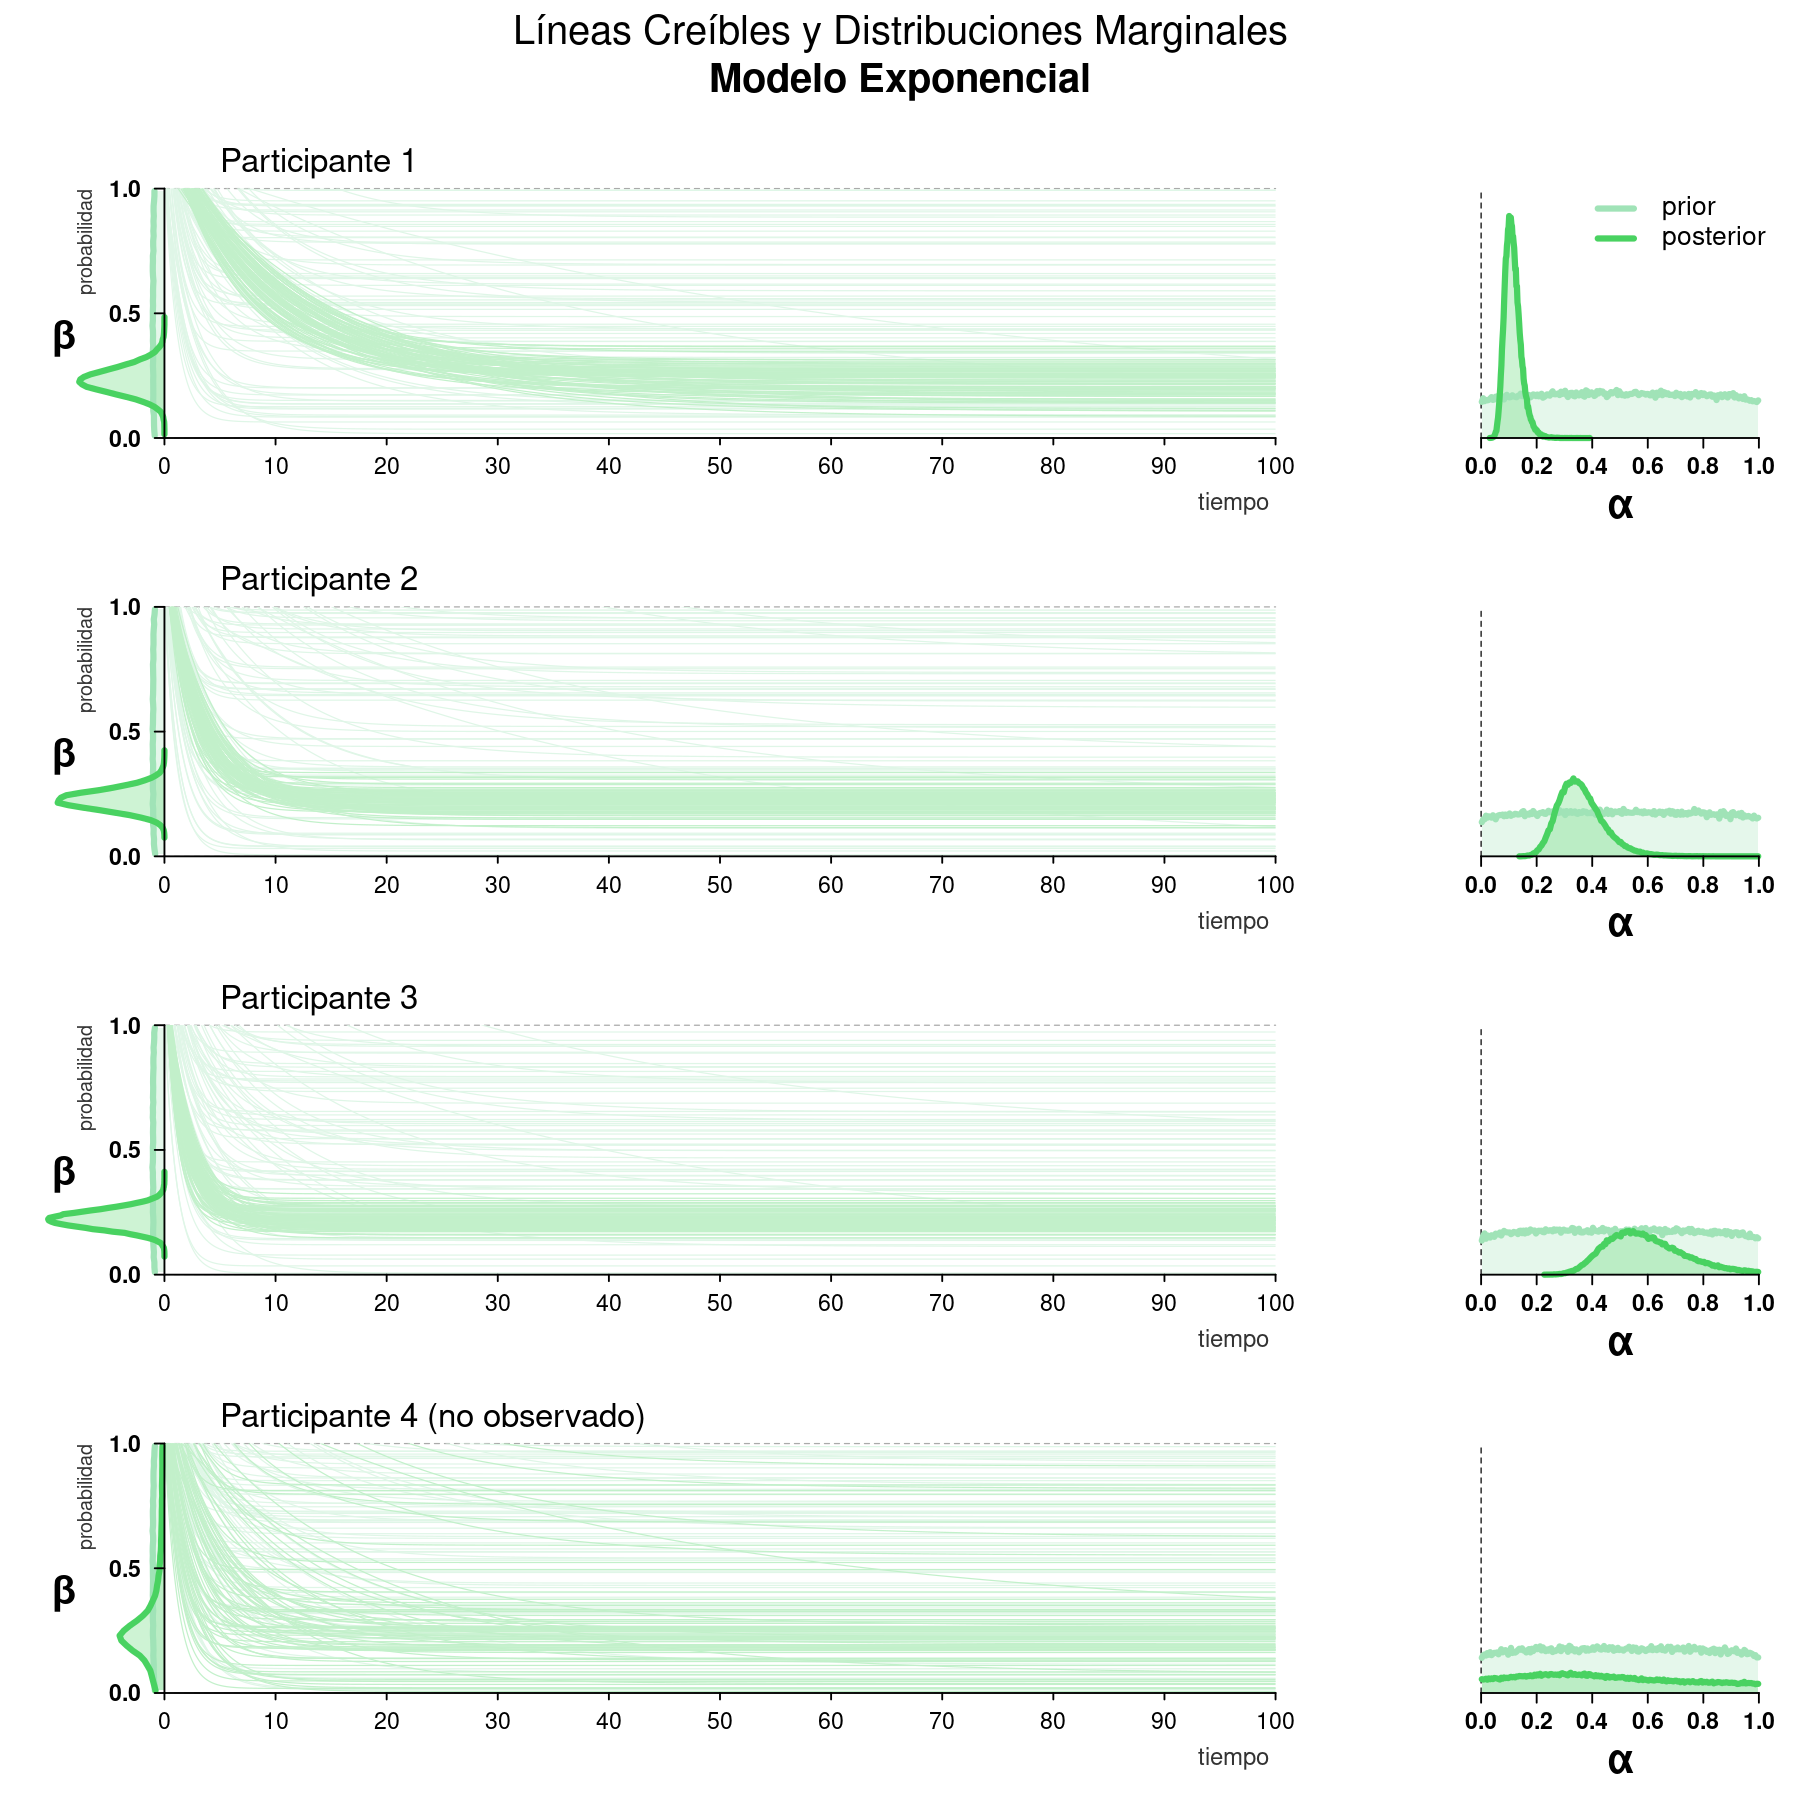

In [31]:
# Marginal Distributions EXPONENTIAL DECAY MODEL

col_prior <- '#a0e3b7'
col_post <- '#49d261'

options(repr.plot.width = 15, repr.plot.height = 15)
layout(matrix(1:8,ncol=2,byrow = T),widths = c(4,1))
par(cex.axis=1.75,mgp=c(2,1.5,0),mar=c(4,0,2,0),oma=c(2,0,6,0))

subj_labels <- paste('Participante',1:4,c(rep('',3),'(no observado)'))

for(subj in 1:4){
  
  plot(NULL,xlim=c(-10,110),ylim=c(0,1.2),axes=F,ann=F)
  segments(x0=rep(0,2),x1=rep(100,2),y0=c(0,1),y1=c(0,1),lty='dashed')
  
  # indexes in JAGS to plot:
  index <- sample(1:dim(nds_logistic$a_post)[1],size=80)
  x_plot <- seq(0,100,0.01)
  clip(0,100,0,1)
  for(i in index){
    alpha_prior <- nds_exponential$alpha_prior[i,subj] # 'nds_4pl' makes things readable as well!
    beta_prior <- nds_exponential$beta_prior[i,subj]
    p_y_prior <- exp(-alpha_prior*x_plot)+beta_prior
    lines(x_plot,p_y_prior,col=col_prior)
  }
  for(i in index){
    alpha_post <- nds_exponential$alpha_post[i,subj]
    beta_post <- nds_exponential$beta_post[i,subj]
    p_y_post <- exp(-alpha_post*x_plot)+beta_post
    lines(x_plot,p_y_post,col=col_post)
  }

  clip(-100,200,-2,2)
  polygon(x=c(-10,110,110,-10),y=c(-.25,-.25,1.15,1.15),col='#ffffffaa',border=NA)
  text(5,1.1,subj_labels[subj],adj=0,cex=2.5)

  # Uncertainty over beta (baseline)
  beta_pst <- hist(nds_exponential$beta_post[,subj],breaks=50,plot=F)
  beta_prr <- hist(nds_exponential$beta_prior[,subj],breaks=50,plot=F)
  prr_dens <- -beta_prr$density
  prr_mids <- beta_prr$mids
  pst_dens <- -beta_pst$density
  pst_mids <- beta_pst$mids
  polygon(x=c(0,prr_dens,0),y=c(head(prr_mids,1),prr_mids,tail(prr_mids,1)),
          col=paste(col_prior,'44',sep=''),border=NA)
  polygon(x=c(0,pst_dens,0),y=c(head(pst_mids,1),pst_mids,tail(pst_mids,1)),
          col=paste(col_post,'44',sep=''),border=NA)
  lines(prr_dens,prr_mids,lwd=5,col=col_prior)
  lines(pst_dens,pst_mids,lwd=5,col=col_post)
  text(-9,.4,'\u03b2',cex=3,font=2,srt=0)
  text(-7,1,'probabilidad',srt=90,adj=1,cex=1.5,col='#333333')
  mtext('tiempo',1,line=3,adj=.875,cex=1.2,col='#333333')    
    
  par(mgp=c(1,1.5,0))
  axis(1,at=seq(0,100,10),pos=0,lwd=1.5,tck=-0.02,font=1)
  par(mgp=c(1,1.5,0))
  axis(2,at=seq(0,1,0.5),las=1,pos=0,lwd=1.5,tck=-0.03,font=2)
  
  # Uncertainty over alpha (decay rate)
  plot(NULL,xlim=c(-.1,1.1),ylim=c(0,21),axes=F,ann=F)
  lines(x=rep(0,2),y=c(0,5*21/6),lty='dashed')
  alpha_pst <- hist(nds_exponential$alpha_post[,subj],breaks=200,plot=F)
  alpha_prr <- hist(nds_exponential$alpha_prior[,subj],breaks=200,plot=F)
  prr_dens <- alpha_prr$density*3
  prr_mids <- alpha_prr$mids
  pst_dens <- alpha_pst$density
  pst_mids <- alpha_pst$mids
  polygon(x=c(head(prr_mids,1),prr_mids,tail(prr_mids,1)),y=c(0,prr_dens,0),
          col=paste(col_prior,'44',sep=''),border=NA)
  polygon(x=c(head(pst_mids,1),pst_mids,tail(pst_mids,1)),y=c(0,pst_dens,0),
          col=paste(col_post,'44',sep=''),border=NA)
  lines(prr_mids,prr_dens,lwd=5,col=col_prior)
  lines(pst_mids,pst_dens,lwd=5,col=col_post)
  mtext('\u03b1',1,line=3.5,cex=2,font=2)
  par(mgp=c(1,1.5,0))
  axis(1,pos=0,lwd=1.5,tck=-0.03,font=2)
  
  if(subj==1){
    segments(x0=rep(0.42,2),x1=rep(0.55,2),y0=c(16.1,14),y1=c(16.1,14),lwd=5,col=c(col_prior,col_post))
    text(0.65,y=c(14,16.1),c('posterior','prior'),cex=2,adj=0)
  }
  
}

mtext('Líneas Creíbles y Distribuciones Marginales',3,outer=T,line=3,cex=2)
mtext('Modelo Exponencial',3,outer=T,line=0,cex=2,font=2)